In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils
import tensorflow as tf
tfk = tf.keras
tf.keras.backend.set_floatx("float64")
import tensorflow_probability as tfp
tfd = tfp.distributions
from keras import backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
%config InlineBackend.figure_format = 'retina'
from keras.layers import Layer
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow_probability.python.layers import DistributionLambda
import tqdm

%matplotlib inline

Using TensorFlow backend.


In [2]:
noise = 1
def neg_log_likelihood_with_dist(y_true, y_pred, sigma = noise):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

In [3]:
def mixture_prior_params(sigma_1, sigma_2, pi, return_sigma=False):
    params = K.variable([sigma_1, sigma_2, pi], name='mixture_prior_params')
    sigma = np.sqrt(pi * sigma_1 ** 2 + (1 - pi) * sigma_2 ** 2)
    return params, sigma
  
def log_mixture_prior_prob(w):
    comp_1_dist = tf.distributions.Normal(0.0, prior_params[0])
    comp_2_dist = tf.distributions.Normal(0.0, prior_params[1])
    comp_1_weight = prior_params[2]
    return K.log(comp_1_weight * comp_1_dist.prob(w) + (1 - comp_1_weight) * comp_2_dist.prob(w))
  
# Mixture prior parameters shared across DenseVariational layer instances
prior_params, prior_sigma = mixture_prior_params(sigma_1=1.0, sigma_2=0.1, pi=0.2)

In [4]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def  posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential(
        [tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n], scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
])

In [5]:
df, scaler, continuous_cols = utils.xform_data(pd.read_csv('task.csv'))

In [6]:
permuts = utils.get_permutations(pd.read_csv('task.csv'), 100)

In [7]:
x_train = df.drop(['log_Target'], axis = 1)
y_train = df['log_Target']

In [8]:
n_epochs = 10000
lr = .01#5e-3
batch_size = x_train.shape[0]

In [9]:
def implement_wape(ys, preds):
    numer8 = np.sum(np.abs(np.array(ys) - np.array(preds)))
    w = 1000 * (numer8)/np.sum(np.abs(ys))
    return w

In [10]:
train_size = len(x_train)
X = []
y = []
X_val = []
y_val = []

space = {'choice': hp.choice('num_layers',
                             [{'layers':'two', },
                              {'layers':'three', 
                               'units3': hp.choice('units3', [32, 64])
                              }
                             ]),
         'units1': hp.choice('units1', [16, 32, 64]),
         'units2': hp.choice('units2', [16, 32, 64]),
         'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
        }

def f_nn(params):   

    print ('Params testing: ', params)
    model_in = Input(shape=(x_train.shape[1],))
    x = tfp.layers.DenseVariational(int('{}'.format(params['units1'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(int('{}'.format(params['units2'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    x = LeakyReLU(0.1)(x)
    
    if params['choice']['layers']== 'three':
        x = tfp.layers.DenseVariational(int('{}'.format(params['choice']['units3'])), posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
        x = LeakyReLU(0.1)(x) 
    
    model_out_loc = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                                                                      model_out_scale])
    model = Model(model_in, model_out)
    model.compile(loss=neg_log_likelihood_with_dist, optimizer=params['optimizer'], metrics=['mse'])
    #early_stop = EarlyStopping(monitor='mse', min_delta = 0, patience=1000, mode='auto')
    
    model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, verbose = 0)#, callbacks = [early_stop])
    print('here')
    y_pred_list = []
    for i in range(len(x_train)):
        tensor = tf.constant([x_train.iloc[i]], dtype='float32')
        pred_list = []
        for j in range(250):
            y_pred = model.predict(tensor)
            pred_list.append(y_pred)
        y_pred_list.append(pred_list)

    y_means = np.mean(y_pred_list, axis = 1)
    y_means = y_means.reshape(len(x_train),)
    wape = implement_wape(y_means, y_train)
    print('WAPE: {}' .format(wape))
    return wape
    
#trials = Trials()
#best = fmin(f_nn, space, algo=tpe.suggest, max_evals=20, trials=trials)
#print('best: ', best)

In [11]:
def build_model(train_size):
    model_in = Input(shape=(train_size,))
    x = tfp.layers.DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(model_in)#32
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(64, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)#32
    x = LeakyReLU(0.1)(x)
    x = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_loc = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out_scale = tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/train_size)(x)
    model_out = DistributionLambda(lambda t: tfd.Normal(loc=t[0],
                                                        scale=1e-7 + tf.math.softplus(1e-3 * t[1])))([model_out_loc,
                                                        model_out_scale])
    model = Model(model_in, model_out)
    return model

model = build_model(x_train.shape[1])
model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
dense_variational (DenseVariati (None, 64)           6720        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64)           0           dense_variational[0][0]          
__________________________________________________________________________________________________
dense_variational_1 (DenseVaria (None, 64)           12480       leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [22]:
#early_stop = EarlyStopping(monitor='mse', min_delta = 0, patience=1000, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor="mse", factor=0.5, patience=400, verbose=1,
                              mode="auto",min_delta=0.0001, min_lr=.00001)
hist = model.fit(x_train, y_train, epochs = n_epochs, callbacks = [reduce_lr] )

Train on 600 samples
Epoch 1/10000
600/600 [==============================] - 1s 2ms/sample - loss: 7648.3277 - mse: 7046.8943
Epoch 2/10000
600/600 [==============================] - 0s 246us/sample - loss: 31127.1334 - mse: 31827.7216
Epoch 3/10000
600/600 [==============================] - 0s 251us/sample - loss: 5500.4997 - mse: 4693.4792
Epoch 4/10000
600/600 [==============================] - 0s 246us/sample - loss: 4036.0826 - mse: 3726.0183
Epoch 5/10000
600/600 [==============================] - 0s 255us/sample - loss: 4727.2549 - mse: 4745.6602
Epoch 6/10000
600/600 [==============================] - 0s 244us/sample - loss: 3627.7379 - mse: 3174.5335
Epoch 7/10000
600/600 [==============================] - 0s 252us/sample - loss: 6129.2039 - mse: 4858.9305
Epoch 8/10000
600/600 [==============================] - 0s 258us/sample - loss: 5616.0043 - mse: 4905.9113
Epoch 9/10000
600/600 [==============================] - 0s 253us/sample - loss: 2828.1933 - mse: 2749.3091
Epoch 1

600/600 [==============================] - 0s 282us/sample - loss: 292.1990 - mse: 285.8809
Epoch 75/10000
600/600 [==============================] - 0s 295us/sample - loss: 297.7965 - mse: 284.8474
Epoch 76/10000
600/600 [==============================] - 0s 294us/sample - loss: 340.2065 - mse: 315.4262
Epoch 77/10000
600/600 [==============================] - 0s 297us/sample - loss: 936.4190 - mse: 853.7036
Epoch 78/10000
600/600 [==============================] - 0s 304us/sample - loss: 339.6371 - mse: 326.6119
Epoch 79/10000
600/600 [==============================] - 0s 309us/sample - loss: 500.7804 - mse: 447.8336
Epoch 80/10000
600/600 [==============================] - 0s 293us/sample - loss: 235.6980 - mse: 225.2881
Epoch 81/10000
600/600 [==============================] - 0s 299us/sample - loss: 201.3168 - mse: 194.3860
Epoch 82/10000
600/600 [==============================] - 0s 293us/sample - loss: 210.3815 - mse: 197.3902
Epoch 83/10000
600/600 [============================

600/600 [==============================] - 0s 287us/sample - loss: 315.2286 - mse: 292.7818
Epoch 151/10000
600/600 [==============================] - 0s 262us/sample - loss: 136.9993 - mse: 133.7709
Epoch 152/10000
600/600 [==============================] - 0s 313us/sample - loss: 59.8826 - mse: 56.2709
Epoch 153/10000
600/600 [==============================] - 0s 316us/sample - loss: 98.3118 - mse: 96.0454
Epoch 154/10000
600/600 [==============================] - 0s 280us/sample - loss: 186.9958 - mse: 176.4398
Epoch 155/10000
600/600 [==============================] - 0s 281us/sample - loss: 162.4107 - mse: 151.5279
Epoch 156/10000
600/600 [==============================] - 0s 295us/sample - loss: 70.1787 - mse: 66.9581
Epoch 157/10000
600/600 [==============================] - 0s 293us/sample - loss: 45.8853 - mse: 44.9967
Epoch 158/10000
600/600 [==============================] - 0s 284us/sample - loss: 135.8269 - mse: 133.6414
Epoch 159/10000
600/600 [===========================

600/600 [==============================] - 0s 276us/sample - loss: 39.4824 - mse: 38.5198
Epoch 228/10000
600/600 [==============================] - 0s 279us/sample - loss: 38.3619 - mse: 37.0767
Epoch 229/10000
600/600 [==============================] - 0s 271us/sample - loss: 69.8216 - mse: 65.8542
Epoch 230/10000
600/600 [==============================] - 0s 274us/sample - loss: 31.4747 - mse: 30.4292
Epoch 231/10000
600/600 [==============================] - 0s 281us/sample - loss: 43.2095 - mse: 41.7496
Epoch 232/10000
600/600 [==============================] - 0s 298us/sample - loss: 35.2638 - mse: 33.1001
Epoch 233/10000
600/600 [==============================] - 0s 280us/sample - loss: 22.8723 - mse: 21.9461
Epoch 234/10000
600/600 [==============================] - 0s 279us/sample - loss: 56.6600 - mse: 54.5395
Epoch 235/10000
600/600 [==============================] - 0s 281us/sample - loss: 20.4757 - mse: 20.3878
Epoch 236/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: 36.2669 - mse: 36.2194
Epoch 305/10000
600/600 [==============================] - 0s 276us/sample - loss: 26.6705 - mse: 24.7656
Epoch 306/10000
600/600 [==============================] - 0s 280us/sample - loss: 12.1022 - mse: 11.4322
Epoch 307/10000
600/600 [==============================] - 0s 278us/sample - loss: 17.5871 - mse: 16.5354
Epoch 308/10000
600/600 [==============================] - 0s 274us/sample - loss: 12.5084 - mse: 12.3026
Epoch 309/10000
600/600 [==============================] - 0s 274us/sample - loss: 20.5314 - mse: 19.3780
Epoch 310/10000
600/600 [==============================] - 0s 278us/sample - loss: 15.1947 - mse: 14.9213
Epoch 311/10000
600/600 [==============================] - 0s 274us/sample - loss: 33.6889 - mse: 31.9347
Epoch 312/10000
600/600 [==============================] - 0s 277us/sample - loss: 36.7375 - mse: 36.6759
Epoch 313/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 303us/sample - loss: 2.7956 - mse: 2.5954
Epoch 382/10000
600/600 [==============================] - 0s 348us/sample - loss: 7.1533 - mse: 6.6267
Epoch 383/10000
600/600 [==============================] - 0s 333us/sample - loss: 6.9468 - mse: 6.7734
Epoch 384/10000
600/600 [==============================] - 0s 346us/sample - loss: 4.7463 - mse: 4.6407
Epoch 385/10000
600/600 [==============================] - 0s 339us/sample - loss: 8.4354 - mse: 7.9976
Epoch 386/10000
600/600 [==============================] - 0s 314us/sample - loss: 11.4538 - mse: 11.3992
Epoch 387/10000
600/600 [==============================] - 0s 289us/sample - loss: 10.9919 - mse: 10.6668
Epoch 388/10000
600/600 [==============================] - 0s 280us/sample - loss: 3.2447 - mse: 3.3117
Epoch 389/10000
600/600 [==============================] - 0s 290us/sample - loss: 15.0932 - mse: 14.2069
Epoch 390/10000
600/600 [==============================] - 0s 283us/sample

600/600 [==============================] - 0s 276us/sample - loss: 3.2670 - mse: 3.0310
Epoch 460/10000
600/600 [==============================] - 0s 278us/sample - loss: 4.8841 - mse: 4.5372
Epoch 461/10000
600/600 [==============================] - 0s 286us/sample - loss: 3.2810 - mse: 3.1731
Epoch 462/10000
600/600 [==============================] - 0s 281us/sample - loss: 3.4667 - mse: 3.1662
Epoch 463/10000
600/600 [==============================] - 0s 269us/sample - loss: 8.7050 - mse: 8.5412
Epoch 464/10000
600/600 [==============================] - 0s 285us/sample - loss: 4.4367 - mse: 4.2612
Epoch 465/10000
600/600 [==============================] - 0s 287us/sample - loss: 3.2072 - mse: 2.9587
Epoch 466/10000
600/600 [==============================] - 0s 282us/sample - loss: 4.1783 - mse: 3.8872
Epoch 467/10000
600/600 [==============================] - 0s 275us/sample - loss: 5.4541 - mse: 5.3456
Epoch 468/10000
600/600 [==============================] - 0s 266us/sample - los

600/600 [==============================] - 0s 268us/sample - loss: 2.8322 - mse: 2.6165
Epoch 538/10000
600/600 [==============================] - 0s 265us/sample - loss: 1.8724 - mse: 1.6982
Epoch 539/10000
600/600 [==============================] - 0s 265us/sample - loss: 1.6614 - mse: 1.5353
Epoch 540/10000
600/600 [==============================] - 0s 264us/sample - loss: 4.6644 - mse: 4.3121
Epoch 541/10000
600/600 [==============================] - 0s 268us/sample - loss: 2.6630 - mse: 2.5788
Epoch 542/10000
600/600 [==============================] - 0s 269us/sample - loss: 1.8209 - mse: 1.7269
Epoch 543/10000
600/600 [==============================] - 0s 267us/sample - loss: 2.2661 - mse: 2.1933
Epoch 544/10000
600/600 [==============================] - 0s 273us/sample - loss: 1.1922 - mse: 1.1659
Epoch 545/10000
600/600 [==============================] - 0s 289us/sample - loss: 1.7846 - mse: 1.8774
Epoch 546/10000
600/600 [==============================] - 0s 289us/sample - los

Epoch 616/10000
600/600 [==============================] - 0s 273us/sample - loss: 1.0505 - mse: 1.0535
Epoch 617/10000
600/600 [==============================] - 0s 268us/sample - loss: 1.0884 - mse: 0.9754
Epoch 618/10000
600/600 [==============================] - 0s 274us/sample - loss: 0.8937 - mse: 0.7964
Epoch 619/10000
600/600 [==============================] - 0s 294us/sample - loss: 0.9721 - mse: 0.8581
Epoch 620/10000
600/600 [==============================] - 0s 297us/sample - loss: 0.9395 - mse: 0.8816
Epoch 621/10000
600/600 [==============================] - 0s 281us/sample - loss: 1.4088 - mse: 1.3040
Epoch 622/10000
600/600 [==============================] - 0s 280us/sample - loss: 0.9173 - mse: 0.7744
Epoch 623/10000
600/600 [==============================] - 0s 276us/sample - loss: 0.9520 - mse: 0.8569
Epoch 624/10000
600/600 [==============================] - 0s 279us/sample - loss: 1.2744 - mse: 1.1598
Epoch 625/10000
600/600 [==============================] - 0s 28

600/600 [==============================] - 0s 281us/sample - loss: 1.1410 - mse: 1.0670
Epoch 695/10000
600/600 [==============================] - 0s 279us/sample - loss: 0.9134 - mse: 0.8280
Epoch 696/10000
600/600 [==============================] - 0s 276us/sample - loss: 1.0973 - mse: 1.0558
Epoch 697/10000
600/600 [==============================] - 0s 282us/sample - loss: 0.8070 - mse: 0.8196
Epoch 698/10000
600/600 [==============================] - 0s 276us/sample - loss: 0.8253 - mse: 0.7253
Epoch 699/10000
600/600 [==============================] - 0s 277us/sample - loss: 0.8306 - mse: 0.7824
Epoch 700/10000
600/600 [==============================] - 0s 279us/sample - loss: 0.9715 - mse: 0.8779
Epoch 701/10000
600/600 [==============================] - 0s 284us/sample - loss: 0.7723 - mse: 0.7264
Epoch 702/10000
600/600 [==============================] - 0s 307us/sample - loss: 0.9441 - mse: 0.8278
Epoch 703/10000
600/600 [==============================] - 0s 282us/sample - los

Epoch 773/10000
600/600 [==============================] - 0s 275us/sample - loss: 0.9442 - mse: 0.8803
Epoch 774/10000
600/600 [==============================] - 0s 279us/sample - loss: 0.8694 - mse: 0.7947
Epoch 775/10000
600/600 [==============================] - 0s 289us/sample - loss: 0.7890 - mse: 0.6980
Epoch 776/10000
600/600 [==============================] - 0s 281us/sample - loss: 0.8381 - mse: 0.7957
Epoch 777/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.8066 - mse: 0.7827
Epoch 778/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.7377 - mse: 0.6160
Epoch 779/10000
600/600 [==============================] - 0s 276us/sample - loss: 0.6880 - mse: 0.6392
Epoch 780/10000
600/600 [==============================] - 0s 281us/sample - loss: 0.8015 - mse: 0.6765
Epoch 781/10000
600/600 [==============================] - 0s 275us/sample - loss: 0.7444 - mse: 0.6802
Epoch 782/10000
600/600 [==============================] - 0s 27

600/600 [==============================] - 0s 288us/sample - loss: 0.6512 - mse: 0.5712
Epoch 852/10000
600/600 [==============================] - 0s 282us/sample - loss: 0.6394 - mse: 0.5122
Epoch 853/10000
600/600 [==============================] - 0s 279us/sample - loss: 0.6461 - mse: 0.5781
Epoch 854/10000
600/600 [==============================] - 0s 301us/sample - loss: 0.6927 - mse: 0.5997
Epoch 855/10000
600/600 [==============================] - 0s 292us/sample - loss: 0.7615 - mse: 0.6843
Epoch 856/10000
600/600 [==============================] - 0s 286us/sample - loss: 0.6598 - mse: 0.5838
Epoch 857/10000
600/600 [==============================] - 0s 283us/sample - loss: 0.8765 - mse: 0.8370
Epoch 858/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.6703 - mse: 0.6130
Epoch 859/10000
600/600 [==============================] - 0s 298us/sample - loss: 0.6703 - mse: 0.6336
Epoch 860/10000
600/600 [==============================] - 0s 277us/sample - los

Epoch 930/10000
600/600 [==============================] - 0s 303us/sample - loss: 0.6752 - mse: 0.6089
Epoch 931/10000
600/600 [==============================] - 0s 327us/sample - loss: 0.6138 - mse: 0.5184
Epoch 932/10000
600/600 [==============================] - 0s 418us/sample - loss: 0.6555 - mse: 0.5859
Epoch 933/10000
600/600 [==============================] - 0s 332us/sample - loss: 0.6411 - mse: 0.5771
Epoch 934/10000
600/600 [==============================] - 0s 353us/sample - loss: 0.6520 - mse: 0.5970
Epoch 935/10000
600/600 [==============================] - 0s 345us/sample - loss: 0.6383 - mse: 0.5785
Epoch 936/10000
600/600 [==============================] - 0s 330us/sample - loss: 0.6517 - mse: 0.5812
Epoch 937/10000
600/600 [==============================] - 0s 311us/sample - loss: 0.6479 - mse: 0.5801
Epoch 938/10000
600/600 [==============================] - 0s 305us/sample - loss: 0.6702 - mse: 0.6156
Epoch 939/10000
600/600 [==============================] - 0s 36

600/600 [==============================] - 0s 272us/sample - loss: 0.6200 - mse: 0.5231
Epoch 1009/10000
600/600 [==============================] - 0s 281us/sample - loss: 0.6389 - mse: 0.5731
Epoch 1010/10000
600/600 [==============================] - 0s 288us/sample - loss: 0.6482 - mse: 0.5552
Epoch 1011/10000
600/600 [==============================] - 0s 302us/sample - loss: 0.6191 - mse: 0.5065
Epoch 1012/10000
600/600 [==============================] - 0s 312us/sample - loss: 0.6134 - mse: 0.5485
Epoch 1013/10000
600/600 [==============================] - 0s 285us/sample - loss: 0.6396 - mse: 0.5300
Epoch 1014/10000
600/600 [==============================] - 0s 285us/sample - loss: 0.6199 - mse: 0.5053
Epoch 1015/10000
600/600 [==============================] - 0s 303us/sample - loss: 0.6133 - mse: 0.4889
Epoch 1016/10000
600/600 [==============================] - 0s 310us/sample - loss: 0.6540 - mse: 0.5627
Epoch 1017/10000
600/600 [==============================] - 0s 311us/sam

600/600 [==============================] - 0s 277us/sample - loss: 0.6207 - mse: 0.5738
Epoch 1087/10000
600/600 [==============================] - 0s 280us/sample - loss: 0.6089 - mse: 0.4972
Epoch 1088/10000
600/600 [==============================] - 0s 290us/sample - loss: 0.5984 - mse: 0.5795
Epoch 1089/10000
600/600 [==============================] - 0s 300us/sample - loss: 0.6065 - mse: 0.4904
Epoch 1090/10000
600/600 [==============================] - 0s 305us/sample - loss: 0.6063 - mse: 0.4971
Epoch 1091/10000
600/600 [==============================] - 0s 304us/sample - loss: 0.6053 - mse: 0.4926
Epoch 1092/10000
600/600 [==============================] - 0s 298us/sample - loss: 0.6096 - mse: 0.5472
Epoch 1093/10000
600/600 [==============================] - 0s 296us/sample - loss: 0.6121 - mse: 0.5670
Epoch 1094/10000
600/600 [==============================] - 0s 292us/sample - loss: 0.6023 - mse: 0.5198
Epoch 1095/10000
600/600 [==============================] - 0s 287us/sam

600/600 [==============================] - 0s 299us/sample - loss: 0.5966 - mse: 0.5038
Epoch 1165/10000
600/600 [==============================] - 0s 283us/sample - loss: 0.6000 - mse: 0.4885
Epoch 1166/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.6007 - mse: 0.5693
Epoch 1167/10000
600/600 [==============================] - 0s 284us/sample - loss: 0.5962 - mse: 0.4761
Epoch 1168/10000
600/600 [==============================] - 0s 271us/sample - loss: 0.6000 - mse: 0.5400
Epoch 1169/10000
600/600 [==============================] - 0s 297us/sample - loss: 0.5923 - mse: 0.4815
Epoch 1170/10000
600/600 [==============================] - 0s 315us/sample - loss: 0.6009 - mse: 0.5387
Epoch 1171/10000
600/600 [==============================] - 0s 346us/sample - loss: 0.5952 - mse: 0.5658
Epoch 1172/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.5991 - mse: 0.5359
Epoch 1173/10000
600/600 [==============================] - 0s 274us/sam

600/600 [==============================] - 0s 275us/sample - loss: 0.5908 - mse: 0.4463
Epoch 1243/10000
600/600 [==============================] - 0s 269us/sample - loss: 0.5904 - mse: 0.5318
Epoch 1244/10000
600/600 [==============================] - 0s 268us/sample - loss: 0.5903 - mse: 0.5162
Epoch 1245/10000
600/600 [==============================] - 0s 276us/sample - loss: 0.5890 - mse: 0.4706
Epoch 1246/10000
600/600 [==============================] - 0s 292us/sample - loss: 0.5896 - mse: 0.5245
Epoch 1247/10000
600/600 [==============================] - 0s 271us/sample - loss: 0.5933 - mse: 0.5021
Epoch 1248/10000
600/600 [==============================] - 0s 268us/sample - loss: 0.5921 - mse: 0.5505
Epoch 1249/10000
600/600 [==============================] - 0s 268us/sample - loss: 0.5872 - mse: 0.5237
Epoch 1250/10000
600/600 [==============================] - 0s 294us/sample - loss: 0.5901 - mse: 0.4650
Epoch 1251/10000
600/600 [==============================] - 0s 288us/sam

600/600 [==============================] - 0s 318us/sample - loss: 0.5842 - mse: 0.4855
Epoch 1321/10000
600/600 [==============================] - ETA: 0s - loss: 0.5822 - mse: 0.516 - 0s 334us/sample - loss: 0.5834 - mse: 0.5116
Epoch 1322/10000
600/600 [==============================] - 0s 330us/sample - loss: 0.5837 - mse: 0.5628
Epoch 1323/10000
600/600 [==============================] - 0s 324us/sample - loss: 0.5831 - mse: 0.4748
Epoch 1324/10000
600/600 [==============================] - ETA: 0s - loss: 0.5867 - mse: 0.484 - 0s 318us/sample - loss: 0.5849 - mse: 0.5187
Epoch 1325/10000
600/600 [==============================] - 0s 318us/sample - loss: 0.5835 - mse: 0.5110
Epoch 1326/10000
600/600 [==============================] - 0s 297us/sample - loss: 0.5843 - mse: 0.4866
Epoch 1327/10000
600/600 [==============================] - 0s 297us/sample - loss: 0.5830 - mse: 0.4669
Epoch 1328/10000
600/600 [==============================] - 0s 295us/sample - loss: 0.5847 - mse: 0.5

Epoch 1397/10000
600/600 [==============================] - 0s 282us/sample - loss: 0.5783 - mse: 0.5101
Epoch 1398/10000
600/600 [==============================] - 0s 283us/sample - loss: 0.5790 - mse: 0.5168
Epoch 1399/10000
600/600 [==============================] - 0s 306us/sample - loss: 0.5785 - mse: 0.5737
Epoch 1400/10000
600/600 [==============================] - 0s 309us/sample - loss: 0.5787 - mse: 0.4980
Epoch 1401/10000
600/600 [==============================] - 0s 274us/sample - loss: 0.5783 - mse: 0.4976
Epoch 1402/10000
600/600 [==============================] - 0s 298us/sample - loss: 0.5780 - mse: 0.5094
Epoch 1403/10000
600/600 [==============================] - 0s 292us/sample - loss: 0.5775 - mse: 0.4928
Epoch 1404/10000
600/600 [==============================] - 0s 296us/sample - loss: 0.5789 - mse: 0.4723
Epoch 1405/10000
600/600 [==============================] - 0s 278us/sample - loss: 0.5786 - mse: 0.4836
Epoch 1406/10000
600/600 [=============================

600/600 [==============================] - 0s 257us/sample - loss: 0.5735 - mse: 0.4697
Epoch 1475/10000
600/600 [==============================] - 0s 253us/sample - loss: 0.5736 - mse: 0.4937
Epoch 1476/10000
600/600 [==============================] - 0s 256us/sample - loss: 0.5734 - mse: 0.5824
Epoch 1477/10000
600/600 [==============================] - 0s 258us/sample - loss: 0.5727 - mse: 0.4782
Epoch 1478/10000
600/600 [==============================] - 0s 253us/sample - loss: 0.5741 - mse: 0.4791
Epoch 1479/10000
600/600 [==============================] - 0s 262us/sample - loss: 0.5733 - mse: 0.4921
Epoch 1480/10000
600/600 [==============================] - 0s 255us/sample - loss: 0.5732 - mse: 0.5315
Epoch 1481/10000
600/600 [==============================] - 0s 256us/sample - loss: 0.5735 - mse: 0.4712
Epoch 1482/10000
600/600 [==============================] - 0s 266us/sample - loss: 0.5723 - mse: 0.5465
Epoch 1483/10000
600/600 [==============================] - 0s 261us/sam

600/600 [==============================] - 0s 258us/sample - loss: 0.4248 - mse: 0.3756
Epoch 1553/10000
600/600 [==============================] - 0s 254us/sample - loss: 0.3471 - mse: 0.2967
Epoch 1554/10000
600/600 [==============================] - 0s 268us/sample - loss: 0.2421 - mse: 0.2503
Epoch 1555/10000
600/600 [==============================] - 0s 294us/sample - loss: 0.1592 - mse: 0.1858
Epoch 1556/10000
600/600 [==============================] - 0s 271us/sample - loss: 0.2697 - mse: 0.2243
Epoch 1557/10000
600/600 [==============================] - 0s 267us/sample - loss: 0.2402 - mse: 0.2559
Epoch 1558/10000
600/600 [==============================] - 0s 269us/sample - loss: 0.1953 - mse: 0.2365
Epoch 1559/10000
600/600 [==============================] - 0s 265us/sample - loss: 0.1179 - mse: 0.1798
Epoch 1560/10000
600/600 [==============================] - 0s 283us/sample - loss: 0.2755 - mse: 0.2081
Epoch 1561/10000
600/600 [==============================] - 0s 274us/sam

600/600 [==============================] - 0s 256us/sample - loss: 0.1162 - mse: 0.1586
Epoch 1630/10000
600/600 [==============================] - 0s 254us/sample - loss: -0.0266 - mse: 0.1318
Epoch 1631/10000
600/600 [==============================] - 0s 257us/sample - loss: -0.1032 - mse: 0.1165
Epoch 1632/10000
600/600 [==============================] - 0s 257us/sample - loss: 0.6181 - mse: 0.2102
Epoch 1633/10000
600/600 [==============================] - 0s 254us/sample - loss: 0.2749 - mse: 0.2734
Epoch 1634/10000
600/600 [==============================] - 0s 255us/sample - loss: 0.2118 - mse: 0.2609
Epoch 1635/10000
600/600 [==============================] - 0s 262us/sample - loss: 0.1288 - mse: 0.1885
Epoch 1636/10000
600/600 [==============================] - 0s 253us/sample - loss: 0.0577 - mse: 0.1790
Epoch 1637/10000
600/600 [==============================] - 0s 264us/sample - loss: -0.0287 - mse: 0.1670
Epoch 1638/10000
600/600 [==============================] - 0s 255us/

600/600 [==============================] - 0s 283us/sample - loss: -0.1169 - mse: 0.1098
Epoch 1707/10000
600/600 [==============================] - 0s 309us/sample - loss: -0.1689 - mse: 0.1143
Epoch 1708/10000
600/600 [==============================] - 0s 305us/sample - loss: -0.1273 - mse: 0.1033
Epoch 1709/10000
600/600 [==============================] - 0s 321us/sample - loss: -0.0864 - mse: 0.1017
Epoch 1710/10000
600/600 [==============================] - 0s 305us/sample - loss: -0.0669 - mse: 0.1124
Epoch 1711/10000
600/600 [==============================] - 0s 323us/sample - loss: -0.0946 - mse: 0.1173
Epoch 1712/10000
600/600 [==============================] - 0s 315us/sample - loss: -0.1815 - mse: 0.1082
Epoch 1713/10000
600/600 [==============================] - 0s 301us/sample - loss: -0.1087 - mse: 0.0964
Epoch 1714/10000
600/600 [==============================] - 0s 308us/sample - loss: -0.0901 - mse: 0.1048
Epoch 1715/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 293us/sample - loss: -0.2262 - mse: 0.0991
Epoch 1784/10000
600/600 [==============================] - 0s 311us/sample - loss: 0.2298 - mse: 0.1306
Epoch 1785/10000
600/600 [==============================] - 0s 298us/sample - loss: 0.0412 - mse: 0.1573
Epoch 1786/10000
600/600 [==============================] - 0s 302us/sample - loss: -0.0671 - mse: 0.1465
Epoch 1787/10000
600/600 [==============================] - 0s 335us/sample - loss: -0.1209 - mse: 0.1149
Epoch 1788/10000
600/600 [==============================] - 0s 294us/sample - loss: -0.1804 - mse: 0.1025
Epoch 1789/10000
600/600 [==============================] - 0s 298us/sample - loss: -0.1937 - mse: 0.1005
Epoch 1790/10000
600/600 [==============================] - 0s 301us/sample - loss: -0.1192 - mse: 0.1035
Epoch 1791/10000
600/600 [==============================] - 0s 313us/sample - loss: -0.2722 - mse: 0.0963
Epoch 1792/10000
600/600 [==============================] - 0s 34

600/600 [==============================] - 0s 359us/sample - loss: -0.2439 - mse: 0.0859
Epoch 1860/10000
600/600 [==============================] - 0s 301us/sample - loss: -0.2227 - mse: 0.0868
Epoch 1861/10000
600/600 [==============================] - 0s 294us/sample - loss: -0.3337 - mse: 0.0768
Epoch 1862/10000
600/600 [==============================] - 0s 336us/sample - loss: -0.3518 - mse: 0.0689
Epoch 1863/10000
600/600 [==============================] - 0s 324us/sample - loss: -0.2966 - mse: 0.0654
Epoch 1864/10000
600/600 [==============================] - 0s 293us/sample - loss: -0.3489 - mse: 0.0650
Epoch 1865/10000
600/600 [==============================] - 0s 338us/sample - loss: -0.2406 - mse: 0.0788
Epoch 1866/10000
600/600 [==============================] - 0s 325us/sample - loss: -0.1944 - mse: 0.0857
Epoch 1867/10000
600/600 [==============================] - 0s 292us/sample - loss: -0.2898 - mse: 0.0798
Epoch 1868/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 267us/sample - loss: -0.3767 - mse: 0.0610
Epoch 1937/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.2192 - mse: 0.0690
Epoch 1938/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.4106 - mse: 0.0635
Epoch 1939/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.3633 - mse: 0.0629
Epoch 1940/10000
600/600 [==============================] - 0s 269us/sample - loss: -0.4180 - mse: 0.0637
Epoch 1941/10000
600/600 [==============================] - 0s 273us/sample - loss: -0.4000 - mse: 0.0656
Epoch 1942/10000
600/600 [==============================] - 0s 273us/sample - loss: -0.1390 - mse: 0.0825
Epoch 1943/10000
600/600 [==============================] - 0s 283us/sample - loss: -0.2768 - mse: 0.0870
Epoch 1944/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.3787 - mse: 0.0630
Epoch 1945/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -0.4753 - mse: 0.0534
Epoch 2014/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.3761 - mse: 0.0559
Epoch 2015/10000
600/600 [==============================] - 0s 269us/sample - loss: -0.4049 - mse: 0.0562
Epoch 2016/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.4306 - mse: 0.0586
Epoch 2017/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.4508 - mse: 0.0594
Epoch 2018/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.5050 - mse: 0.0469
Epoch 2019/10000
600/600 [==============================] - 0s 275us/sample - loss: -0.4637 - mse: 0.0509
Epoch 2020/10000
600/600 [==============================] - 0s 282us/sample - loss: -0.4830 - mse: 0.0570
Epoch 2021/10000
600/600 [==============================] - 0s 287us/sample - loss: -0.4036 - mse: 0.0558
Epoch 2022/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 282us/sample - loss: -0.4995 - mse: 0.0480
Epoch 2091/10000
600/600 [==============================] - 0s 283us/sample - loss: -0.4551 - mse: 0.0511
Epoch 2092/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.5162 - mse: 0.0584
Epoch 2093/10000
600/600 [==============================] - 0s 278us/sample - loss: -0.4786 - mse: 0.0523
Epoch 2094/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.5093 - mse: 0.0501
Epoch 2095/10000
600/600 [==============================] - 0s 282us/sample - loss: -0.4466 - mse: 0.0577
Epoch 2096/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.5312 - mse: 0.0538
Epoch 2097/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.5505 - mse: 0.0494
Epoch 2098/10000
600/600 [==============================] - 0s 281us/sample - loss: -0.6135 - mse: 0.0431
Epoch 2099/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 284us/sample - loss: -0.6353 - mse: 0.0388
Epoch 2168/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.6609 - mse: 0.0405
Epoch 2169/10000
600/600 [==============================] - 0s 277us/sample - loss: -0.5931 - mse: 0.0410
Epoch 2170/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.5758 - mse: 0.0438
Epoch 2171/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.5677 - mse: 0.0428
Epoch 2172/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.3354 - mse: 0.0593
Epoch 2173/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.4484 - mse: 0.0569
Epoch 2174/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.5092 - mse: 0.0544
Epoch 2175/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.5421 - mse: 0.0485
Epoch 2176/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 271us/sample - loss: -0.4658 - mse: 0.0450
Epoch 2245/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.5960 - mse: 0.0467
Epoch 2246/10000
600/600 [==============================] - 0s 269us/sample - loss: -0.7253 - mse: 0.0419
Epoch 2247/10000
600/600 [==============================] - 0s 277us/sample - loss: -0.7116 - mse: 0.0343
Epoch 2248/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.7759 - mse: 0.0338
Epoch 2249/10000
600/600 [==============================] - 0s 273us/sample - loss: -0.7336 - mse: 0.0303
Epoch 2250/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.6141 - mse: 0.0374
Epoch 2251/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.6963 - mse: 0.0372
Epoch 2252/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.7374 - mse: 0.0343
Epoch 2253/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 273us/sample - loss: -0.8448 - mse: 0.0278
Epoch 2322/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.6193 - mse: 0.0342
Epoch 2323/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.7973 - mse: 0.0297
Epoch 2324/10000
600/600 [==============================] - 0s 278us/sample - loss: -0.7836 - mse: 0.0314
Epoch 2325/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.6610 - mse: 0.0328
Epoch 2326/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.7922 - mse: 0.0324
Epoch 2327/10000
600/600 [==============================] - 0s 277us/sample - loss: -0.7177 - mse: 0.0303
Epoch 2328/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.8462 - mse: 0.0321
Epoch 2329/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.5463 - mse: 0.0339
Epoch 2330/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 282us/sample - loss: -0.6545 - mse: 0.0316
Epoch 2399/10000
600/600 [==============================] - 0s 283us/sample - loss: -0.7858 - mse: 0.0284
Epoch 2400/10000
600/600 [==============================] - 0s 282us/sample - loss: -0.5896 - mse: 0.0386
Epoch 2401/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.7031 - mse: 0.0328
Epoch 2402/10000
600/600 [==============================] - 0s 282us/sample - loss: -0.6702 - mse: 0.0345
Epoch 2403/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.7394 - mse: 0.0316
Epoch 2404/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.8505 - mse: 0.0307
Epoch 2405/10000
600/600 [==============================] - 0s 268us/sample - loss: -0.9270 - mse: 0.0245
Epoch 2406/10000
600/600 [==============================] - 0s 273us/sample - loss: -0.8858 - mse: 0.0272
Epoch 2407/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 281us/sample - loss: -1.0138 - mse: 0.0198
Epoch 2476/10000
600/600 [==============================] - 0s 281us/sample - loss: -0.3413 - mse: 0.0302
Epoch 2477/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.8235 - mse: 0.0309
Epoch 2478/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.9383 - mse: 0.0273
Epoch 2479/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.9747 - mse: 0.0228
Epoch 2480/10000
600/600 [==============================] - 0s 277us/sample - loss: -0.9984 - mse: 0.0191
Epoch 2481/10000
600/600 [==============================] - 0s 284us/sample - loss: -0.9940 - mse: 0.0219
Epoch 2482/10000
600/600 [==============================] - 0s 273us/sample - loss: -0.7129 - mse: 0.0268
Epoch 2483/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.0033 - mse: 0.0225
Epoch 2484/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -1.0527 - mse: 0.0186
Epoch 2553/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.9865 - mse: 0.0184
Epoch 2554/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.1106 - mse: 0.0192
Epoch 2555/10000
600/600 [==============================] - 0s 272us/sample - loss: -0.9023 - mse: 0.0180
Epoch 2556/10000
600/600 [==============================] - 0s 285us/sample - loss: -0.9880 - mse: 0.0209
Epoch 2557/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.1583 - mse: 0.0192
Epoch 2558/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.0891 - mse: 0.0162
Epoch 2559/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.0227 - mse: 0.0172
Epoch 2560/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.5755 - mse: 0.0244
Epoch 2561/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 274us/sample - loss: -1.1966 - mse: 0.0173
Epoch 2630/10000
600/600 [==============================] - 0s 275us/sample - loss: -1.2389 - mse: 0.0143
Epoch 2631/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.7935 - mse: 0.0202
Epoch 2632/10000
600/600 [==============================] - 0s 282us/sample - loss: -0.7924 - mse: 0.0209
Epoch 2633/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.1444 - mse: 0.0188
Epoch 2634/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.1255 - mse: 0.0189
Epoch 2635/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.1236 - mse: 0.0152
Epoch 2636/10000
600/600 [==============================] - 0s 278us/sample - loss: -1.2155 - mse: 0.0131
Epoch 2637/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.1676 - mse: 0.0155
Epoch 2638/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 290us/sample - loss: -1.2519 - mse: 0.0141
Epoch 2707/10000
600/600 [==============================] - 0s 287us/sample - loss: -1.2607 - mse: 0.0131
Epoch 2708/10000
600/600 [==============================] - 0s 284us/sample - loss: -0.0926 - mse: 0.0297
Epoch 2709/10000
600/600 [==============================] - 0s 279us/sample - loss: -0.9673 - mse: 0.0241
Epoch 2710/10000
600/600 [==============================] - 0s 284us/sample - loss: -1.0981 - mse: 0.0222
Epoch 2711/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.0459 - mse: 0.0196
Epoch 2712/10000
600/600 [==============================] - 0s 279us/sample - loss: -1.1510 - mse: 0.0175
Epoch 2713/10000
600/600 [==============================] - 0s 276us/sample - loss: -1.2613 - mse: 0.0144
Epoch 2714/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.1660 - mse: 0.0142
Epoch 2715/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 288us/sample - loss: -0.9350 - mse: 0.0200
Epoch 2784/10000
600/600 [==============================] - 0s 277us/sample - loss: -1.1783 - mse: 0.0170
Epoch 2785/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.2765 - mse: 0.0133
Epoch 2786/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.3858 - mse: 0.0116
Epoch 2787/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.3591 - mse: 0.0121
Epoch 2788/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.2863 - mse: 0.0108
Epoch 2789/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.2337 - mse: 0.0112
Epoch 2790/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.4466 - mse: 0.0104
Epoch 2791/10000
600/600 [==============================] - 0s 268us/sample - loss: -1.3930 - mse: 0.0103
Epoch 2792/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -1.2459 - mse: 0.0131
Epoch 2861/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.3156 - mse: 0.0124
Epoch 2862/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.4099 - mse: 0.0097
Epoch 2863/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.4169 - mse: 0.0098
Epoch 2864/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.4782 - mse: 0.0086
Epoch 2865/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.3023 - mse: 0.0100
Epoch 2866/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.8840 - mse: 0.0142
Epoch 2867/10000
600/600 [==============================] - 0s 274us/sample - loss: -1.3812 - mse: 0.0118
Epoch 2868/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.1000 - mse: 0.0145
Epoch 2869/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 332us/sample - loss: -1.1178 - mse: 0.0127
Epoch 2938/10000
600/600 [==============================] - 0s 334us/sample - loss: -1.4310 - mse: 0.0117
Epoch 2939/10000
600/600 [==============================] - 0s 315us/sample - loss: -1.4589 - mse: 0.0103
Epoch 2940/10000
600/600 [==============================] - 0s 343us/sample - loss: -1.5573 - mse: 0.0094
Epoch 2941/10000
600/600 [==============================] - 0s 309us/sample - loss: -1.5376 - mse: 0.0089
Epoch 2942/10000
600/600 [==============================] - 0s 327us/sample - loss: -1.6071 - mse: 0.0077
Epoch 2943/10000
600/600 [==============================] - 0s 337us/sample - loss: -1.2217 - mse: 0.0098
Epoch 2944/10000
600/600 [==============================] - 0s 291us/sample - loss: -1.1657 - mse: 0.0120
Epoch 2945/10000
600/600 [==============================] - 0s 327us/sample - loss: -1.4135 - mse: 0.0107
Epoch 2946/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 268us/sample - loss: -0.6538 - mse: 0.0180
Epoch 3015/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.2794 - mse: 0.0149
Epoch 3016/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.4300 - mse: 0.0109
Epoch 3017/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.5113 - mse: 0.0095
Epoch 3018/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.5608 - mse: 0.0080
Epoch 3019/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.5412 - mse: 0.0080
Epoch 3020/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.3973 - mse: 0.0079
Epoch 3021/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.5523 - mse: 0.0081
Epoch 3022/10000
600/600 [==============================] - 0s 276us/sample - loss: -1.4817 - mse: 0.0077
Epoch 3023/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 275us/sample - loss: -1.3208 - mse: 0.0088
Epoch 3092/10000
600/600 [==============================] - 0s 275us/sample - loss: -1.3846 - mse: 0.0090
Epoch 3093/10000
600/600 [==============================] - 0s 276us/sample - loss: -1.3016 - mse: 0.0093
Epoch 3094/10000
600/600 [==============================] - 0s 277us/sample - loss: -1.4021 - mse: 0.0094
Epoch 3095/10000
600/600 [==============================] - 0s 274us/sample - loss: -1.4647 - mse: 0.0074
Epoch 3096/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.6111 - mse: 0.0078
Epoch 3097/10000
600/600 [==============================] - 0s 287us/sample - loss: -1.6501 - mse: 0.0072
Epoch 3098/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.6358 - mse: 0.0104
Epoch 3099/10000
600/600 [==============================] - 0s 280us/sample - loss: -0.8680 - mse: 0.0168
Epoch 3100/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 273us/sample - loss: -1.4623 - mse: 0.0085
Epoch 3169/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.4099 - mse: 0.0085
Epoch 3170/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.6727 - mse: 0.0060
Epoch 3171/10000
600/600 [==============================] - 0s 268us/sample - loss: -1.5280 - mse: 0.0080
Epoch 3172/10000
600/600 [==============================] - 0s 274us/sample - loss: -1.6756 - mse: 0.0056
Epoch 3173/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.2970 - mse: 0.0074
Epoch 3174/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.3194 - mse: 0.0087
Epoch 3175/10000
600/600 [==============================] - 0s 279us/sample - loss: -1.3466 - mse: 0.0081
Epoch 3176/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.5204 - mse: 0.0075
Epoch 3177/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 281us/sample - loss: -1.7078 - mse: 0.0065
Epoch 3246/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.6286 - mse: 0.0067
Epoch 3247/10000
600/600 [==============================] - 0s 284us/sample - loss: -1.7121 - mse: 0.0058
Epoch 3248/10000
600/600 [==============================] - 0s 279us/sample - loss: -1.7770 - mse: 0.0055
Epoch 3249/10000
600/600 [==============================] - 0s 279us/sample - loss: -1.6839 - mse: 0.0067
Epoch 3250/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.2822 - mse: 0.0076
Epoch 3251/10000
600/600 [==============================] - 0s 285us/sample - loss: -1.7428 - mse: 0.0061
Epoch 3252/10000
600/600 [==============================] - 0s 279us/sample - loss: -1.4469 - mse: 0.0064
Epoch 3253/10000
600/600 [==============================] - 0s 283us/sample - loss: -1.5990 - mse: 0.0063
Epoch 3254/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 297us/sample - loss: -1.1738 - mse: 0.0072
Epoch 3323/10000
600/600 [==============================] - 0s 284us/sample - loss: -1.2611 - mse: 0.0088
Epoch 3324/10000
600/600 [==============================] - 0s 284us/sample - loss: -1.7182 - mse: 0.0071
Epoch 3325/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.6652 - mse: 0.0066
Epoch 3326/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.6941 - mse: 0.0059
Epoch 3327/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.7423 - mse: 0.0057
Epoch 3328/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.7522 - mse: 0.0048
Epoch 3329/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.5960 - mse: 0.0058
Epoch 3330/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.6250 - mse: 0.0056
Epoch 3331/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 285us/sample - loss: -1.6690 - mse: 0.0052
Epoch 3400/10000
600/600 [==============================] - 0s 277us/sample - loss: -1.4293 - mse: 0.0062
Epoch 3401/10000
600/600 [==============================] - 0s 277us/sample - loss: -1.8184 - mse: 0.0047
Epoch 3402/10000
600/600 [==============================] - 0s 278us/sample - loss: -1.9034 - mse: 0.0044
Epoch 3403/10000
600/600 [==============================] - 0s 278us/sample - loss: -1.9331 - mse: 0.0041
Epoch 3404/10000
600/600 [==============================] - 0s 275us/sample - loss: 0.5393 - mse: 0.0133
Epoch 3405/10000
600/600 [==============================] - 0s 269us/sample - loss: -0.6157 - mse: 0.0236
Epoch 3406/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.2702 - mse: 0.0131
Epoch 3407/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.4445 - mse: 0.0123
Epoch 3408/10000
600/600 [==============================] - 0s 2

600/600 [==============================] - 0s 290us/sample - loss: -2.0554 - mse: 0.0029
Epoch 3477/10000
600/600 [==============================] - 0s 286us/sample - loss: -1.8934 - mse: 0.0033
Epoch 3478/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.9893 - mse: 0.0037
Epoch 3479/10000
600/600 [==============================] - 0s 275us/sample - loss: -1.7795 - mse: 0.0034
Epoch 3480/10000
600/600 [==============================] - 0s 270us/sample - loss: 0.0840 - mse: 0.0099
Epoch 3481/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.3849 - mse: 0.0096
Epoch 3482/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.6856 - mse: 0.0068
Epoch 3483/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.7599 - mse: 0.0055
Epoch 3484/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.8014 - mse: 0.0053
Epoch 3485/10000
600/600 [==============================] - 0s 2

600/600 [==============================] - 0s 275us/sample - loss: -1.7683 - mse: 0.0052
Epoch 3554/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.8529 - mse: 0.0048
Epoch 3555/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.9265 - mse: 0.0047
Epoch 3556/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.0457 - mse: 0.0036
Epoch 3557/10000
600/600 [==============================] - 0s 268us/sample - loss: -1.7370 - mse: 0.0042
Epoch 3558/10000
600/600 [==============================] - 0s 274us/sample - loss: -1.5553 - mse: 0.0043
Epoch 3559/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.2369 - mse: 0.0076
Epoch 3560/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.7760 - mse: 0.0049
Epoch 3561/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.9092 - mse: 0.0044
Epoch 3562/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 274us/sample - loss: -1.8758 - mse: 0.0041
Epoch 3631/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.9400 - mse: 0.0037
Epoch 3632/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.8792 - mse: 0.0038
Epoch 3633/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.4631 - mse: 0.0050
Epoch 3634/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.8661 - mse: 0.0042
Epoch 3635/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.7906 - mse: 0.0041
Epoch 3636/10000
600/600 [==============================] - 0s 275us/sample - loss: -1.7700 - mse: 0.0045
Epoch 3637/10000
600/600 [==============================] - 0s 274us/sample - loss: -1.9314 - mse: 0.0037
Epoch 3638/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.8679 - mse: 0.0040
Epoch 3639/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -2.0740 - mse: 0.0028
Epoch 3708/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.1511 - mse: 0.0022
Epoch 3709/10000
600/600 [==============================] - 0s 271us/sample - loss: -0.5143 - mse: 0.0060
Epoch 3710/10000
600/600 [==============================] - 0s 270us/sample - loss: -0.7482 - mse: 0.0084
Epoch 3711/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.7387 - mse: 0.0055
Epoch 3712/10000
600/600 [==============================] - 0s 275us/sample - loss: -1.8687 - mse: 0.0041
Epoch 3713/10000
600/600 [==============================] - 0s 285us/sample - loss: -1.9050 - mse: 0.0041
Epoch 3714/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.9836 - mse: 0.0036
Epoch 3715/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.6933 - mse: 0.0046
Epoch 3716/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 284us/sample - loss: -2.0584 - mse: 0.0033
Epoch 3785/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.0896 - mse: 0.0028
Epoch 3786/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.9092 - mse: 0.0032
Epoch 3787/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.0827 - mse: 0.0026
Epoch 3788/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.0708 - mse: 0.0027
Epoch 3789/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.6926 - mse: 0.0038
Epoch 3790/10000
600/600 [==============================] - 0s 283us/sample - loss: -1.9628 - mse: 0.0029
Epoch 3791/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.1958 - mse: 0.0022
Epoch 3792/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.2116 - mse: 0.0028
Epoch 3793/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 273us/sample - loss: -1.1354 - mse: 0.0041
Epoch 3862/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.8681 - mse: 0.0037
Epoch 3863/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.0963 - mse: 0.0031
Epoch 3864/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.2052 - mse: 0.0024
Epoch 3865/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.1606 - mse: 0.0024
Epoch 3866/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.0479 - mse: 0.0028
Epoch 3867/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.0179 - mse: 0.0025
Epoch 3868/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.1864 - mse: 0.0022
Epoch 3869/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.2866 - mse: 0.0020
Epoch 3870/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 277us/sample - loss: -2.2575 - mse: 0.0020
Epoch 3939/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.1070 - mse: 0.0020
Epoch 3940/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.1848 - mse: 0.0037
Epoch 3941/10000
600/600 [==============================] - 0s 273us/sample - loss: -1.9678 - mse: 0.0026
Epoch 3942/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.1764 - mse: 0.0023
Epoch 3943/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.2108 - mse: 0.0023
Epoch 3944/10000
600/600 [==============================] - 0s 275us/sample - loss: -2.1907 - mse: 0.0024
Epoch 3945/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.1734 - mse: 0.0024
Epoch 3946/10000
600/600 [==============================] - 0s 274us/sample - loss: -0.0823 - mse: 0.0064
Epoch 3947/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 306us/sample - loss: -2.0430 - mse: 0.0027
Epoch 4016/10000
600/600 [==============================] - 0s 300us/sample - loss: -2.1979 - mse: 0.0021
Epoch 4017/10000
600/600 [==============================] - 0s 297us/sample - loss: -2.0787 - mse: 0.0025
Epoch 4018/10000
600/600 [==============================] - 0s 286us/sample - loss: -2.1928 - mse: 0.0021
Epoch 4019/10000
600/600 [==============================] - 0s 296us/sample - loss: -2.1127 - mse: 0.0026
Epoch 4020/10000
600/600 [==============================] - 0s 310us/sample - loss: -1.6454 - mse: 0.0032
Epoch 4021/10000
600/600 [==============================] - 0s 301us/sample - loss: -1.9355 - mse: 0.0031
Epoch 4022/10000
600/600 [==============================] - 0s 319us/sample - loss: -2.1386 - mse: 0.0027
Epoch 4023/10000
600/600 [==============================] - 0s 295us/sample - loss: -1.9018 - mse: 0.0026
Epoch 4024/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 280us/sample - loss: -2.1675 - mse: 0.0021
Epoch 4093/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.3366 - mse: 0.0038
Epoch 4094/10000
600/600 [==============================] - 0s 288us/sample - loss: -2.0853 - mse: 0.0028
Epoch 4095/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.0752 - mse: 0.0028
Epoch 4096/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.2438 - mse: 0.0023
Epoch 4097/10000
600/600 [==============================] - 0s 291us/sample - loss: -2.2040 - mse: 0.0022
Epoch 4098/10000
600/600 [==============================] - 0s 278us/sample - loss: -1.9298 - mse: 0.0027
Epoch 4099/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.2163 - mse: 0.0022
Epoch 4100/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.1688 - mse: 0.0021
Epoch 4101/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 276us/sample - loss: -2.2050 - mse: 0.0024
Epoch 4170/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.0502 - mse: 0.0023
Epoch 4171/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.2923 - mse: 0.0021
Epoch 4172/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.0211 - mse: 0.0025
Epoch 4173/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.2116 - mse: 0.0020
Epoch 4174/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.2463 - mse: 0.0024
Epoch 4175/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.1492 - mse: 0.0019
Epoch 4176/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.0800 - mse: 0.0023
Epoch 4177/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.1964 - mse: 0.0020
Epoch 4178/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 286us/sample - loss: -1.7078 - mse: 0.0024
Epoch 4247/10000
600/600 [==============================] - 0s 278us/sample - loss: -1.9166 - mse: 0.0026
Epoch 4248/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.0027 - mse: 0.0027
Epoch 4249/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.2147 - mse: 0.0021
Epoch 4250/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.2991 - mse: 0.0020
Epoch 4251/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.3093 - mse: 0.0020
Epoch 4252/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.4232 - mse: 0.0016
Epoch 4253/10000
600/600 [==============================] - 0s 269us/sample - loss: -1.2298 - mse: 0.0035
Epoch 4254/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.5146 - mse: 0.0040
Epoch 4255/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 286us/sample - loss: -2.1188 - mse: 0.0026
Epoch 4324/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.2709 - mse: 0.0023
Epoch 4325/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.3114 - mse: 0.0019
Epoch 4326/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.0292 - mse: 0.0023
Epoch 4327/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.3524 - mse: 0.0021
Epoch 4328/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.9564 - mse: 0.0024
Epoch 4329/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.8905 - mse: 0.0025
Epoch 4330/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.0532 - mse: 0.0026
Epoch 4331/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.2789 - mse: 0.0020
Epoch 4332/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 282us/sample - loss: -2.1834 - mse: 0.0022
Epoch 4401/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.3433 - mse: 0.0020
Epoch 4402/10000
600/600 [==============================] - 0s 287us/sample - loss: -2.1997 - mse: 0.0021
Epoch 4403/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.3280 - mse: 0.0017
Epoch 4404/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.4449 - mse: 0.0014
Epoch 4405/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.1060 - mse: 0.0016
Epoch 4406/10000
600/600 [==============================] - 0s 284us/sample - loss: -1.6920 - mse: 0.0027
Epoch 4407/10000
600/600 [==============================] - 0s 285us/sample - loss: -2.1026 - mse: 0.0023
Epoch 4408/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.1089 - mse: 0.0022
Epoch 4409/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -1.8911 - mse: 0.0023
Epoch 4478/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.4083 - mse: 0.0016
Epoch 4479/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.3150 - mse: 0.0015
Epoch 4480/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.3503 - mse: 0.0015
Epoch 4481/10000
600/600 [==============================] - 0s 281us/sample - loss: -1.8514 - mse: 0.0025
Epoch 4482/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.0383 - mse: 0.0023
Epoch 4483/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.0470 - mse: 0.0021
Epoch 4484/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.0475 - mse: 0.0021
Epoch 4485/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.3203 - mse: 0.0015
Epoch 4486/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 281us/sample - loss: -2.2979 - mse: 0.0018
Epoch 4555/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.4113 - mse: 0.0016
Epoch 4556/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.0381 - mse: 0.0021
Epoch 4557/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.1922 - mse: 0.0019
Epoch 4558/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.4548 - mse: 0.0014
Epoch 4559/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.3200 - mse: 0.0019
Epoch 4560/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.0784 - mse: 0.0018
Epoch 4561/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.3402 - mse: 0.0015
Epoch 4562/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.3137 - mse: 0.0017
Epoch 4563/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 285us/sample - loss: -2.3998 - mse: 0.0017
Epoch 4632/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.3379 - mse: 0.0015
Epoch 4633/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.1110 - mse: 0.0032
Epoch 4634/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.2422 - mse: 0.0038
Epoch 4635/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.1059 - mse: 0.0027
Epoch 4636/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.2079 - mse: 0.0022
Epoch 4637/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.2519 - mse: 0.0021
Epoch 4638/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.1883 - mse: 0.0026
Epoch 4639/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.2083 - mse: 0.0023
Epoch 4640/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 269us/sample - loss: -2.2296 - mse: 0.0017
Epoch 4709/10000
600/600 [==============================] - 0s 268us/sample - loss: -1.7713 - mse: 0.0022
Epoch 4710/10000
600/600 [==============================] - 0s 275us/sample - loss: -2.4357 - mse: 0.0016
Epoch 4711/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.4721 - mse: 0.0013
Epoch 4712/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.1441 - mse: 0.0030
Epoch 4713/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.2812 - mse: 0.0022
Epoch 4714/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.3668 - mse: 0.0017
Epoch 4715/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.3358 - mse: 0.0016
Epoch 4716/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.1992 - mse: 0.0019
Epoch 4717/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 274us/sample - loss: -2.5084 - mse: 0.0011
Epoch 4786/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.6011 - mse: 0.0011
Epoch 4787/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.3807 - mse: 0.0013
Epoch 4788/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.6557 - mse: 0.0021
Epoch 4789/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.7278 - mse: 0.0024
Epoch 4790/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.1818 - mse: 0.0020
Epoch 4791/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.4416 - mse: 0.0013
Epoch 4792/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.3247 - mse: 0.0015
Epoch 4793/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.0503 - mse: 0.0019
Epoch 4794/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 272us/sample - loss: -2.2525 - mse: 0.0022
Epoch 4863/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.3493 - mse: 0.0016
Epoch 4864/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.4331 - mse: 0.0014
Epoch 4865/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.4551 - mse: 0.0013
Epoch 4866/10000
600/600 [==============================] - 0s 290us/sample - loss: -2.3388 - mse: 0.0016
Epoch 4867/10000
600/600 [==============================] - 0s 287us/sample - loss: -2.4647 - mse: 0.0015
Epoch 4868/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.5409 - mse: 0.0013
Epoch 4869/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.5513 - mse: 0.0011
Epoch 4870/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.3884 - mse: 0.0012
Epoch 4871/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 270us/sample - loss: -2.2864 - mse: 0.0015
Epoch 4940/10000
600/600 [==============================] - 0s 280us/sample - loss: -1.4789 - mse: 0.0026
Epoch 4941/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.1884 - mse: 0.0018
Epoch 4942/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.4503 - mse: 0.0013
Epoch 4943/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.5039 - mse: 0.0013
Epoch 4944/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.4848 - mse: 0.0013
Epoch 4945/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.5901 - mse: 0.0012
Epoch 4946/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.4802 - mse: 0.0012
Epoch 4947/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.5499 - mse: 0.0012
Epoch 4948/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 282us/sample - loss: -1.7274 - mse: 0.0026
Epoch 5017/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.3393 - mse: 0.0018
Epoch 5018/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.4874 - mse: 0.0013
Epoch 5019/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.5769 - mse: 0.0013
Epoch 5020/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.6273 - mse: 0.0010
Epoch 5021/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.4527 - mse: 0.0013
Epoch 5022/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.3372 - mse: 0.0012
Epoch 5023/10000
600/600 [==============================] - 0s 275us/sample - loss: -2.5703 - mse: 0.0011
Epoch 5024/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.1018 - mse: 0.0015
Epoch 5025/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 275us/sample - loss: -1.7506 - mse: 0.0028
Epoch 5094/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.2610 - mse: 0.0020
Epoch 5095/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.3451 - mse: 0.0018
Epoch 5096/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.4042 - mse: 0.0017
Epoch 5097/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.4681 - mse: 0.0016
Epoch 5098/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.5195 - mse: 0.0016
Epoch 5099/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.5527 - mse: 0.0013
Epoch 5100/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.4385 - mse: 0.0012
Epoch 5101/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.3585 - mse: 0.0014
Epoch 5102/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 281us/sample - loss: -2.4879 - mse: 0.0013
Epoch 5171/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.5821 - mse: 0.0012
Epoch 5172/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.6384 - mse: 0.0011
Epoch 5173/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.5826 - mse: 0.0010
Epoch 5174/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.6021 - mse: 8.6281e-04
Epoch 5175/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.5152 - mse: 9.7489e-04
Epoch 5176/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5587 - mse: 0.0011
Epoch 5177/10000
600/600 [==============================] - 0s 275us/sample - loss: -2.5131 - mse: 0.0011
Epoch 5178/10000
600/600 [==============================] - 0s 272us/sample - loss: -1.9646 - mse: 0.0017
Epoch 5179/10000
600/600 [=============================

600/600 [==============================] - 0s 272us/sample - loss: -2.5988 - mse: 0.0010
Epoch 5248/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.6063 - mse: 0.0011
Epoch 5249/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.6958 - mse: 8.8564e-04
Epoch 5250/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.3918 - mse: 0.0011
Epoch 5251/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.4197 - mse: 0.0010
Epoch 5252/10000
600/600 [==============================] - 0s 271us/sample - loss: -1.8436 - mse: 0.0016
Epoch 5253/10000
600/600 [==============================] - 0s 275us/sample - loss: -2.2496 - mse: 0.0013
Epoch 5254/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.2887 - mse: 0.0013
Epoch 5255/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.4937 - mse: 0.0011
Epoch 5256/10000
600/600 [==============================] -

600/600 [==============================] - 0s 271us/sample - loss: -1.9535 - mse: 0.0018
Epoch 5325/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.4037 - mse: 0.0014
Epoch 5326/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.3987 - mse: 0.0014
Epoch 5327/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5214 - mse: 0.0013
Epoch 5328/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5808 - mse: 0.0010
Epoch 5329/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.5999 - mse: 0.0011
Epoch 5330/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.6229 - mse: 9.3589e-04
Epoch 5331/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.5650 - mse: 0.0010
Epoch 5332/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.5404 - mse: 0.0011
Epoch 5333/10000
600/600 [==============================] -

600/600 [==============================] - 0s 272us/sample - loss: -1.5730 - mse: 0.0022
Epoch 5401/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.4517 - mse: 0.0014
Epoch 5402/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.5019 - mse: 0.0014
Epoch 5403/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.5909 - mse: 0.0012
Epoch 5404/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5052 - mse: 0.0011
Epoch 5405/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.4364 - mse: 0.0013
Epoch 5406/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.4730 - mse: 0.0011
Epoch 5407/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.4116 - mse: 0.0012
Epoch 5408/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.5974 - mse: 0.0010
Epoch 5409/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 275us/sample - loss: -2.5210 - mse: 9.2501e-04
Epoch 5477/10000
600/600 [==============================] - 0s 282us/sample - loss: -1.5559 - mse: 0.0018
Epoch 5478/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.3339 - mse: 0.0014
Epoch 5479/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.3852 - mse: 0.0013
Epoch 5480/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.6526 - mse: 9.4684e-04
Epoch 5481/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.6669 - mse: 9.6650e-04
Epoch 5482/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.1704 - mse: 0.0014
Epoch 5483/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.0091 - mse: 0.0015
Epoch 5484/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.5919 - mse: 0.0013
Epoch 5485/10000
600/600 [=========================

600/600 [==============================] - 0s 281us/sample - loss: -2.5992 - mse: 0.0011
Epoch 5553/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.5902 - mse: 0.0011
Epoch 5554/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.6673 - mse: 8.9595e-04
Epoch 5555/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.5848 - mse: 9.3347e-04
Epoch 5556/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.0085 - mse: 0.0014
Epoch 5557/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.5681 - mse: 0.0010
Epoch 5558/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.7010 - mse: 8.8578e-04
Epoch 5559/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.7403 - mse: 9.0904e-04
Epoch 5560/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.7538 - mse: 9.5531e-04
Epoch 5561/10000
600/600 [=================

600/600 [==============================] - 0s 284us/sample - loss: -2.6451 - mse: 0.0012
Epoch 5629/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.6447 - mse: 9.4244e-04
Epoch 5630/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.7229 - mse: 8.4614e-04
Epoch 5631/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.2846 - mse: 0.0013
Epoch 5632/10000
600/600 [==============================] - 0s 270us/sample - loss: -1.7152 - mse: 0.0017
Epoch 5633/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5476 - mse: 0.0013
Epoch 5634/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.5525 - mse: 0.0012
Epoch 5635/10000
600/600 [==============================] - 0s 276us/sample - loss: -2.6843 - mse: 0.0010
Epoch 5636/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.5821 - mse: 9.5657e-04
Epoch 5637/10000
600/600 [=========================

600/600 [==============================] - 0s 274us/sample - loss: -2.5599 - mse: 0.0012
Epoch 5705/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.5847 - mse: 0.0012
Epoch 5706/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5539 - mse: 0.0011
Epoch 5707/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.5837 - mse: 0.0012
Epoch 5708/10000
600/600 [==============================] - 0s 271us/sample - loss: -2.4739 - mse: 0.0011
Epoch 5709/10000
600/600 [==============================] - 0s 270us/sample - loss: -2.5979 - mse: 0.0011
Epoch 5710/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.4357 - mse: 0.0012
Epoch 5711/10000
600/600 [==============================] - 0s 268us/sample - loss: -2.4060 - mse: 0.0011
Epoch 5712/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.3560 - mse: 0.0012
Epoch 5713/10000
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 276us/sample - loss: -2.9598 - mse: 6.6866e-04
Epoch 5780/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.8979 - mse: 5.7803e-04
Epoch 5781/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.8557 - mse: 6.3085e-04
Epoch 5782/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.4935 - mse: 6.9260e-04
Epoch 5783/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.5772 - mse: 6.3448e-04
Epoch 5784/10000
600/600 [==============================] - 0s 274us/sample - loss: -2.8657 - mse: 5.3956e-04
Epoch 5785/10000
600/600 [==============================] - 0s 273us/sample - loss: -2.9010 - mse: 6.3821e-04
Epoch 5786/10000
600/600 [==============================] - 0s 269us/sample - loss: -2.8507 - mse: 6.1962e-04
Epoch 5787/10000
600/600 [==============================] - 0s 273us/sample - loss: -3.0305 - mse: 5.4114e-04
Epoch 5788/10000
600/600 [=

600/600 [==============================] - 0s 269us/sample - loss: -2.7568 - mse: 6.4314e-04
Epoch 5854/10000
600/600 [==============================] - 0s 272us/sample - loss: -2.7785 - mse: 6.6621e-04
Epoch 5855/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.8978 - mse: 5.0045e-04
Epoch 5856/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.0054 - mse: 5.4067e-04
Epoch 5857/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.9941 - mse: 4.9571e-04
Epoch 5858/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.8240 - mse: 5.1657e-04
Epoch 5859/10000
600/600 [==============================] - 0s 277us/sample - loss: -2.6525 - mse: 5.2699e-04
Epoch 5860/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.9851 - mse: 4.8371e-04
Epoch 5861/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.7816 - mse: 5.7253e-04
Epoch 5862/10000
600/600 [=

600/600 [==============================] - 0s 282us/sample - loss: -2.4226 - mse: 6.8337e-04
Epoch 5928/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.6129 - mse: 6.7100e-04
Epoch 5929/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.9185 - mse: 5.1026e-04
Epoch 5930/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.1387 - mse: 4.5266e-04
Epoch 5931/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.1134 - mse: 4.0375e-04
Epoch 5932/10000
600/600 [==============================] - 0s 289us/sample - loss: -3.1319 - mse: 4.5422e-04
Epoch 5933/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.1238 - mse: 3.5692e-04
Epoch 5934/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.0062 - mse: 4.3636e-04
Epoch 5935/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.9380 - mse: 4.3243e-04
Epoch 5936/10000
600/600 [=

600/600 [==============================] - 0s 310us/sample - loss: -3.0220 - mse: 5.1284e-04
Epoch 6002/10000
600/600 [==============================] - 0s 302us/sample - loss: -3.0527 - mse: 4.8724e-04
Epoch 6003/10000
600/600 [==============================] - 0s 296us/sample - loss: -3.0220 - mse: 4.3955e-04
Epoch 6004/10000
600/600 [==============================] - 0s 297us/sample - loss: -3.0312 - mse: 5.0442e-04
Epoch 6005/10000
600/600 [==============================] - 0s 294us/sample - loss: -3.0284 - mse: 4.8289e-04
Epoch 6006/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.1408 - mse: 3.6844e-04
Epoch 6007/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.0700 - mse: 4.9678e-04
Epoch 6008/10000
600/600 [==============================] - 0s 285us/sample - loss: -3.0649 - mse: 4.3495e-04
Epoch 6009/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.0978 - mse: 4.6198e-04
Epoch 6010/10000
600/600 [=

600/600 [==============================] - 0s 283us/sample - loss: -2.8860 - mse: 5.2973e-04
Epoch 6076/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.1767 - mse: 4.1789e-04
Epoch 6077/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.1086 - mse: 3.7922e-04
Epoch 6078/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.0748 - mse: 4.1187e-04
Epoch 6079/10000
600/600 [==============================] - 0s 284us/sample - loss: -2.8982 - mse: 4.2849e-04
Epoch 6080/10000
600/600 [==============================] - 0s 278us/sample - loss: -2.6079 - mse: 5.1969e-04
Epoch 6081/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.7965 - mse: 4.9420e-04
Epoch 6082/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.9256 - mse: 4.5895e-04
Epoch 6083/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.1304 - mse: 3.5452e-04
Epoch 6084/10000
600/600 [=

600/600 [==============================] - 0s 330us/sample - loss: -2.6615 - mse: 5.4084e-04
Epoch 6150/10000
600/600 [==============================] - 0s 326us/sample - loss: -2.9082 - mse: 4.4683e-04
Epoch 6151/10000
600/600 [==============================] - 0s 351us/sample - loss: -3.1342 - mse: 3.9571e-04
Epoch 6152/10000
600/600 [==============================] - 0s 366us/sample - loss: -3.2134 - mse: 3.6047e-04
Epoch 6153/10000
600/600 [==============================] - 0s 345us/sample - loss: -3.0538 - mse: 4.0961e-04
Epoch 6154/10000
600/600 [==============================] - 0s 342us/sample - loss: -2.7161 - mse: 4.3808e-04
Epoch 6155/10000
600/600 [==============================] - 0s 367us/sample - loss: -1.4811 - mse: 7.9164e-04
Epoch 6156/10000
600/600 [==============================] - 0s 368us/sample - loss: -2.9557 - mse: 4.9078e-04
Epoch 6157/10000
600/600 [==============================] - 0s 312us/sample - loss: -2.8547 - mse: 4.2773e-04
Epoch 6158/10000
600/600 [=

600/600 [==============================] - 0s 328us/sample - loss: -2.9287 - mse: 3.7839e-04
Epoch 6224/10000
600/600 [==============================] - 0s 349us/sample - loss: -3.1384 - mse: 3.8004e-04
Epoch 6225/10000
600/600 [==============================] - 0s 341us/sample - loss: -3.2090 - mse: 3.7167e-04
Epoch 6226/10000
600/600 [==============================] - 0s 329us/sample - loss: -3.1915 - mse: 3.5335e-04
Epoch 6227/10000
600/600 [==============================] - 0s 364us/sample - loss: -3.1572 - mse: 4.2882e-04
Epoch 6228/10000
600/600 [==============================] - 0s 314us/sample - loss: -3.0114 - mse: 3.7439e-04
Epoch 6229/10000
600/600 [==============================] - 0s 335us/sample - loss: -2.9194 - mse: 4.1516e-04
Epoch 6230/10000
600/600 [==============================] - 0s 351us/sample - loss: -2.7059 - mse: 5.3004e-04
Epoch 6231/10000
600/600 [==============================] - 0s 331us/sample - loss: -2.0946 - mse: 6.1748e-04
Epoch 6232/10000
600/600 [=

600/600 [==============================] - 0s 352us/sample - loss: -2.5848 - mse: 5.1957e-04
Epoch 6298/10000
600/600 [==============================] - 0s 302us/sample - loss: -2.9483 - mse: 4.4632e-04
Epoch 6299/10000
600/600 [==============================] - 0s 350us/sample - loss: -3.1461 - mse: 4.0902e-04
Epoch 6300/10000
600/600 [==============================] - 0s 333us/sample - loss: -3.1253 - mse: 3.8846e-04
Epoch 6301/10000
600/600 [==============================] - 0s 293us/sample - loss: -2.8908 - mse: 4.8500e-04
Epoch 6302/10000
600/600 [==============================] - 0s 338us/sample - loss: -2.9126 - mse: 4.8469e-04
Epoch 6303/10000
600/600 [==============================] - 0s 343us/sample - loss: -1.6928 - mse: 7.9780e-04
Epoch 6304/10000
600/600 [==============================] - 0s 340us/sample - loss: -1.9573 - mse: 8.9209e-04
Epoch 6305/10000
600/600 [==============================] - 0s 315us/sample - loss: -2.7606 - mse: 5.2894e-04
Epoch 6306/10000
600/600 [=

600/600 [==============================] - 0s 343us/sample - loss: -2.9744 - mse: 3.8624e-04
Epoch 6372/10000
600/600 [==============================] - 0s 350us/sample - loss: -3.2382 - mse: 4.1510e-04
Epoch 6373/10000
600/600 [==============================] - 0s 367us/sample - loss: -3.2160 - mse: 3.6817e-04
Epoch 6374/10000
600/600 [==============================] - 0s 305us/sample - loss: -3.2389 - mse: 3.3575e-04
Epoch 6375/10000
600/600 [==============================] - 0s 351us/sample - loss: -2.9835 - mse: 3.7607e-04
Epoch 6376/10000
600/600 [==============================] - 0s 354us/sample - loss: -3.1791 - mse: 3.4823e-04
Epoch 6377/10000
600/600 [==============================] - 0s 340us/sample - loss: -2.1485 - mse: 6.2369e-04
Epoch 6378/10000
600/600 [==============================] - 0s 343us/sample - loss: -1.5596 - mse: 7.6993e-04
Epoch 6379/10000
600/600 [==============================] - 0s 375us/sample - loss: -2.9918 - mse: 4.8736e-04
Epoch 6380/10000
600/600 [=

600/600 [==============================] - 0s 349us/sample - loss: -3.4022 - mse: 2.7428e-04
Epoch 6445/10000
600/600 [==============================] - 0s 351us/sample - loss: -3.0661 - mse: 2.8992e-04
Epoch 6446/10000
600/600 [==============================] - 0s 334us/sample - loss: -3.3105 - mse: 2.4602e-04
Epoch 6447/10000
600/600 [==============================] - 0s 325us/sample - loss: -3.3929 - mse: 2.4738e-04
Epoch 6448/10000
600/600 [==============================] - 0s 353us/sample - loss: -3.4119 - mse: 2.9403e-04
Epoch 6449/10000
600/600 [==============================] - 0s 335us/sample - loss: -3.4712 - mse: 2.4275e-04
Epoch 6450/10000
600/600 [==============================] - 0s 327us/sample - loss: -3.4381 - mse: 2.4011e-04
Epoch 6451/10000
600/600 [==============================] - 0s 306us/sample - loss: -3.4806 - mse: 2.1505e-04
Epoch 6452/10000
600/600 [==============================] - 0s 355us/sample - loss: -3.2375 - mse: 2.6353e-04
Epoch 6453/10000
600/600 [=

600/600 [==============================] - 0s 292us/sample - loss: -2.9139 - mse: 3.1652e-04
Epoch 6519/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.3879 - mse: 2.6584e-04
Epoch 6520/10000
600/600 [==============================] - 0s 287us/sample - loss: -3.1419 - mse: 2.8874e-04
Epoch 6521/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.5418 - mse: 3.5819e-04
Epoch 6522/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.0597 - mse: 3.0686e-04
Epoch 6523/10000
600/600 [==============================] - 0s 281us/sample - loss: -2.9192 - mse: 3.0451e-04
Epoch 6524/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.1387 - mse: 3.1880e-04
Epoch 6525/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.0548 - mse: 3.1976e-04
Epoch 6526/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.3561 - mse: 2.7247e-04
Epoch 6527/10000
600/600 [=

600/600 [==============================] - 0s 281us/sample - loss: -3.2899 - mse: 2.2482e-04
Epoch 6593/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.4230 - mse: 2.1226e-04
Epoch 6594/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.3423 - mse: 2.2282e-04
Epoch 6595/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.0041 - mse: 2.8226e-04
Epoch 6596/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.2733 - mse: 3.7936e-04
Epoch 6597/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.0230 - mse: 4.2399e-04
Epoch 6598/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.3956 - mse: 2.5154e-04
Epoch 6599/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.4301 - mse: 1.9201e-04
Epoch 6600/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.4176 - mse: 1.9654e-04
Epoch 6601/10000
600/600 [=

600/600 [==============================] - 0s 333us/sample - loss: -2.9252 - mse: 2.7207e-04
Epoch 6667/10000
600/600 [==============================] - 0s 358us/sample - loss: -2.5776 - mse: 2.6812e-04
Epoch 6668/10000
600/600 [==============================] - 0s 349us/sample - loss: -2.6414 - mse: 4.0319e-04
Epoch 6669/10000
600/600 [==============================] - 0s 337us/sample - loss: -3.4227 - mse: 2.0736e-04
Epoch 6670/10000
600/600 [==============================] - 0s 353us/sample - loss: -3.4006 - mse: 2.2617e-04
Epoch 6671/10000
600/600 [==============================] - 0s 356us/sample - loss: -3.4736 - mse: 2.1254e-04
Epoch 6672/10000
600/600 [==============================] - 0s 349us/sample - loss: -3.5942 - mse: 1.7986e-04
Epoch 6673/10000
600/600 [==============================] - 0s 352us/sample - loss: -3.5289 - mse: 2.0055e-04
Epoch 6674/10000
600/600 [==============================] - 0s 372us/sample - loss: -3.5846 - mse: 2.1818e-04
Epoch 6675/10000
600/600 [=

600/600 [==============================] - 0s 329us/sample - loss: -3.2885 - mse: 2.5091e-04
Epoch 6741/10000
600/600 [==============================] - 0s 295us/sample - loss: -3.2872 - mse: 2.2498e-04
Epoch 6742/10000
600/600 [==============================] - 0s 313us/sample - loss: -3.3364 - mse: 2.0550e-04
Epoch 6743/10000
600/600 [==============================] - 0s 342us/sample - loss: -3.3518 - mse: 2.2684e-04
Epoch 6744/10000
600/600 [==============================] - 0s 297us/sample - loss: -3.4896 - mse: 2.3226e-04
Epoch 6745/10000
600/600 [==============================] - 0s 332us/sample - loss: -3.5198 - mse: 1.8365e-04
Epoch 6746/10000
600/600 [==============================] - 0s 331us/sample - loss: -3.0772 - mse: 2.4504e-04
Epoch 6747/10000
600/600 [==============================] - 0s 321us/sample - loss: -3.0747 - mse: 2.5481e-04
Epoch 6748/10000
600/600 [==============================] - 0s 353us/sample - loss: -3.3755 - mse: 2.5200e-04
Epoch 6749/10000
600/600 [=

600/600 [==============================] - 0s 319us/sample - loss: -1.9578 - mse: 3.6056e-04
Epoch 6815/10000
600/600 [==============================] - 0s 299us/sample - loss: -2.4878 - mse: 3.3081e-04
Epoch 6816/10000
600/600 [==============================] - 0s 341us/sample - loss: -2.8378 - mse: 2.7272e-04
Epoch 6817/10000
600/600 [==============================] - 0s 293us/sample - loss: -3.2624 - mse: 2.4460e-04
Epoch 6818/10000
600/600 [==============================] - 0s 329us/sample - loss: -3.3876 - mse: 2.2413e-04
Epoch 6819/10000
600/600 [==============================] - 0s 322us/sample - loss: -3.2125 - mse: 2.4022e-04
Epoch 6820/10000
600/600 [==============================] - 0s 287us/sample - loss: -3.5030 - mse: 2.0560e-04
Epoch 6821/10000
600/600 [==============================] - 0s 295us/sample - loss: -3.2414 - mse: 2.3058e-04
Epoch 6822/10000
600/600 [==============================] - 0s 298us/sample - loss: -3.2862 - mse: 2.3239e-04
Epoch 6823/10000
600/600 [=

600/600 [==============================] - 0s 285us/sample - loss: -3.6573 - mse: 2.0652e-04
Epoch 6888/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.6807 - mse: 1.6485e-04
Epoch 6889/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.6053 - mse: 1.7284e-04
Epoch 6890/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.4868 - mse: 1.6149e-04
Epoch 6891/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.4757 - mse: 1.9265e-04
Epoch 6892/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.4491 - mse: 2.1491e-04
Epoch 6893/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.5559 - mse: 2.0097e-04
Epoch 6894/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.4593 - mse: 1.9530e-04
Epoch 6895/10000
600/600 [==============================] - 0s 287us/sample - loss: -3.3993 - mse: 1.7813e-04
Epoch 6896/10000
600/600 [=

600/600 [==============================] - 0s 283us/sample - loss: -3.6928 - mse: 1.4022e-04
Epoch 6962/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.6484 - mse: 1.2015e-04
Epoch 6963/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.6909 - mse: 1.4812e-04
Epoch 6964/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.3644 - mse: 1.5278e-04
Epoch 6965/10000
600/600 [==============================] - 0s 282us/sample - loss: -2.8916 - mse: 2.2259e-04
Epoch 6966/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.4131 - mse: 1.7746e-04
Epoch 6967/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.6841 - mse: 1.5303e-04
Epoch 6968/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.4653 - mse: 1.8376e-04
Epoch 6969/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.3277 - mse: 1.8160e-04
Epoch 6970/10000
600/600 [=

600/600 [==============================] - 0s 284us/sample - loss: -3.5378 - mse: 1.2940e-04
Epoch 7036/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.4196 - mse: 1.7732e-04
Epoch 7037/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.7938 - mse: 1.1822e-04
Epoch 7038/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.7391 - mse: 1.2581e-04
Epoch 7039/10000
600/600 [==============================] - 0s 283us/sample - loss: -2.5157 - mse: 2.3507e-04
Epoch 7040/10000
600/600 [==============================] - 0s 279us/sample - loss: -2.8568 - mse: 1.9228e-04
Epoch 7041/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.0719 - mse: 2.3029e-04
Epoch 7042/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.5771 - mse: 1.7848e-04
Epoch 7043/10000
600/600 [==============================] - 0s 304us/sample - loss: -3.7285 - mse: 1.5923e-04
Epoch 7044/10000
600/600 [=

600/600 [==============================] - 0s 294us/sample - loss: -3.8423 - mse: 1.3168e-04
Epoch 7110/10000
600/600 [==============================] - 0s 324us/sample - loss: -3.8728 - mse: 1.2003e-04
Epoch 7111/10000
600/600 [==============================] - 0s 314us/sample - loss: -3.6341 - mse: 1.3802e-04
Epoch 7112/10000
600/600 [==============================] - 0s 297us/sample - loss: -3.6731 - mse: 1.3641e-04
Epoch 7113/10000
600/600 [==============================] - 0s 335us/sample - loss: -3.7337 - mse: 1.4626e-04
Epoch 7114/10000
600/600 [==============================] - 0s 305us/sample - loss: -3.7883 - mse: 1.0970e-04
Epoch 7115/10000
600/600 [==============================] - 0s 335us/sample - loss: -3.7077 - mse: 1.2307e-04
Epoch 7116/10000
600/600 [==============================] - 0s 327us/sample - loss: -3.0025 - mse: 1.6966e-04
Epoch 7117/10000
600/600 [==============================] - 0s 315us/sample - loss: -3.1358 - mse: 1.7532e-04
Epoch 7118/10000
600/600 [=

600/600 [==============================] - 0s 277us/sample - loss: -2.7421 - mse: 1.6970e-04
Epoch 7184/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.7882 - mse: 1.0512e-04
Epoch 7185/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.8474 - mse: 9.5749e-05
Epoch 7186/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.4873 - mse: 1.3377e-04
Epoch 7187/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.6659 - mse: 1.3862e-04
Epoch 7188/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.7831 - mse: 1.3336e-04
Epoch 7189/10000
600/600 [==============================] - 0s 285us/sample - loss: -3.8670 - mse: 1.1158e-04
Epoch 7190/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.6294 - mse: 1.1069e-04
Epoch 7191/10000
600/600 [==============================] - 0s 270us/sample - loss: -3.1106 - mse: 1.6265e-04
Epoch 7192/10000
600/600 [=

600/600 [==============================] - 0s 285us/sample - loss: -3.8239 - mse: 1.0452e-04
Epoch 7258/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.8902 - mse: 9.5769e-05
Epoch 7259/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.8217 - mse: 1.0802e-04
Epoch 7260/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.7415 - mse: 1.2097e-04
Epoch 7261/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.8579 - mse: 1.1585e-04
Epoch 7262/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.8274 - mse: 1.0515e-04
Epoch 7263/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.6280 - mse: 1.1144e-04
Epoch 7264/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.2772 - mse: 1.6620e-04
Epoch 7265/10000
600/600 [==============================] - 0s 273us/sample - loss: -3.8478 - mse: 1.1606e-04
Epoch 7266/10000
600/600 [=

600/600 [==============================] - 0s 282us/sample - loss: -3.8330 - mse: 9.6438e-05
Epoch 7332/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.7851 - mse: 1.0904e-04
Epoch 7333/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.7603 - mse: 1.0586e-04
Epoch 7334/10000
600/600 [==============================] - 0s 285us/sample - loss: -3.9264 - mse: 1.0743e-04
Epoch 7335/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.7698 - mse: 1.0964e-04
Epoch 7336/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.7831 - mse: 1.0781e-04
Epoch 7337/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.6554 - mse: 1.1516e-04
Epoch 7338/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.6450 - mse: 1.1171e-04
Epoch 7339/10000
600/600 [==============================] - 0s 284us/sample - loss: -3.5570 - mse: 1.1730e-04
Epoch 7340/10000
600/600 [=

600/600 [==============================] - 0s 280us/sample - loss: -3.9719 - mse: 1.0504e-04
Epoch 7405/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.8997 - mse: 1.1064e-04
Epoch 7406/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.9331 - mse: 1.0205e-04
Epoch 7407/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.9126 - mse: 8.4668e-05
Epoch 7408/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.9534 - mse: 1.0119e-04
Epoch 7409/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.0159 - mse: 7.5312e-05
Epoch 7410/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.9723 - mse: 9.0244e-05
Epoch 7411/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.0094 - mse: 1.0401e-04
Epoch 7412/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.8620 - mse: 1.0616e-04
Epoch 7413/10000
600/600 [=

600/600 [==============================] - 0s 282us/sample - loss: -3.6998 - mse: 1.2155e-04
Epoch 7479/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.7469 - mse: 1.0170e-04
Epoch 7480/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.9743 - mse: 8.5721e-05
Epoch 7481/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.9345 - mse: 1.0219e-04
Epoch 7482/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.9944 - mse: 7.9387e-05
Epoch 7483/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.9963 - mse: 9.1928e-05
Epoch 7484/10000
600/600 [==============================] - 0s 283us/sample - loss: -4.0215 - mse: 7.9313e-05
Epoch 7485/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.8067 - mse: 8.6726e-05
Epoch 7486/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.8144 - mse: 9.2865e-05
Epoch 7487/10000
600/600 [=

600/600 [==============================] - 0s 285us/sample - loss: -3.9602 - mse: 8.5416e-05
Epoch 7553/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.9653 - mse: 7.8134e-05
Epoch 7554/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.0329 - mse: 7.8183e-05
Epoch 7555/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.0333 - mse: 8.7911e-05
Epoch 7556/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.9392 - mse: 7.5066e-05
Epoch 7557/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.9989 - mse: 9.2955e-05
Epoch 7558/10000
600/600 [==============================] - 0s 287us/sample - loss: -3.7152 - mse: 8.8754e-05
Epoch 7559/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.9680 - mse: 9.0825e-05
Epoch 7560/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.0355 - mse: 8.3415e-05
Epoch 7561/10000
600/600 [=

600/600 [==============================] - 0s 273us/sample - loss: -3.8998 - mse: 6.8348e-05
Epoch 7627/10000
600/600 [==============================] - 0s 272us/sample - loss: -3.4521 - mse: 9.8053e-05
Epoch 7628/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.7244 - mse: 7.6000e-05
Epoch 7629/10000
600/600 [==============================] - 0s 283us/sample - loss: -3.9200 - mse: 8.3905e-05
Epoch 7630/10000
600/600 [==============================] - 0s 285us/sample - loss: -4.0118 - mse: 7.7769e-05
Epoch 7631/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.0098 - mse: 8.2117e-05
Epoch 7632/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.0629 - mse: 7.7528e-05
Epoch 7633/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.6543 - mse: 8.8468e-05
Epoch 7634/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.8433 - mse: 9.6715e-05
Epoch 7635/10000
600/600 [=

600/600 [==============================] - 0s 275us/sample - loss: -4.0112 - mse: 9.4989e-05
Epoch 7701/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.1060 - mse: 7.8987e-05
Epoch 7702/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.0774 - mse: 7.7445e-05
Epoch 7703/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.8990 - mse: 8.8696e-05
Epoch 7704/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.5526 - mse: 9.1435e-05
Epoch 7705/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.0473 - mse: 8.2799e-05
Epoch 7706/10000
600/600 [==============================] - 0s 283us/sample - loss: -4.1028 - mse: 6.9851e-05
Epoch 7707/10000
600/600 [==============================] - 0s 279us/sample - loss: -3.9754 - mse: 8.1201e-05
Epoch 7708/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.7059 - mse: 8.2626e-05
Epoch 7709/10000
600/600 [=

600/600 [==============================] - 0s 281us/sample - loss: -3.7994 - mse: 8.2637e-05
Epoch 7775/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.8542 - mse: 7.4136e-05
Epoch 7776/10000
600/600 [==============================] - 0s 283us/sample - loss: -4.0639 - mse: 7.0739e-05
Epoch 7777/10000
600/600 [==============================] - 0s 278us/sample - loss: -3.9266 - mse: 8.4433e-05
Epoch 7778/10000
600/600 [==============================] - 0s 280us/sample - loss: -3.9055 - mse: 7.1198e-05
Epoch 7779/10000
600/600 [==============================] - 0s 284us/sample - loss: -4.0800 - mse: 7.2721e-05
Epoch 7780/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.6691 - mse: 8.5389e-05
Epoch 7781/10000
600/600 [==============================] - 0s 280us/sample - loss: -2.8196 - mse: 1.0823e-04
Epoch 7782/10000
600/600 [==============================] - 0s 282us/sample - loss: -3.7810 - mse: 7.1054e-05
Epoch 7783/10000
600/600 [=

600/600 [==============================] - 0s 283us/sample - loss: -4.1764 - mse: 7.1621e-05
Epoch 7848/10000
600/600 [==============================] - 0s 286us/sample - loss: -4.0036 - mse: 7.4383e-05
Epoch 7849/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.0829 - mse: 7.2453e-05
Epoch 7850/10000
600/600 [==============================] - 0s 283us/sample - loss: -4.1179 - mse: 6.0043e-05
Epoch 7851/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.0538 - mse: 7.4992e-05
Epoch 7852/10000
600/600 [==============================] - 0s 277us/sample - loss: -4.1160 - mse: 6.3947e-05
Epoch 7853/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.0260 - mse: 8.3197e-05
Epoch 7854/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.1199 - mse: 6.8637e-05
Epoch 7855/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.0670 - mse: 6.4640e-05
Epoch 7856/10000
600/600 [=

600/600 [==============================] - 0s 280us/sample - loss: -4.0068 - mse: 7.6807e-05
Epoch 7922/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.0595 - mse: 7.2427e-05
Epoch 7923/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.1893 - mse: 5.7785e-05
Epoch 7924/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.0932 - mse: 7.0859e-05
Epoch 7925/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.1573 - mse: 7.0908e-05
Epoch 7926/10000
600/600 [==============================] - 0s 277us/sample - loss: -4.2086 - mse: 7.1364e-05
Epoch 7927/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.1905 - mse: 7.0580e-05
Epoch 7928/10000
600/600 [==============================] - 0s 274us/sample - loss: -4.1720 - mse: 7.0908e-05
Epoch 7929/10000
600/600 [==============================] - 0s 269us/sample - loss: -4.1963 - mse: 6.4290e-05
Epoch 7930/10000
600/600 [=

600/600 [==============================] - 0s 280us/sample - loss: -4.0704 - mse: 6.3857e-05
Epoch 7996/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.0783 - mse: 7.4833e-05
Epoch 7997/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.0864 - mse: 5.5802e-05
Epoch 7998/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.1746 - mse: 5.3679e-05
Epoch 7999/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.0339 - mse: 6.5203e-05
Epoch 8000/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.1564 - mse: 5.8499e-05
Epoch 8001/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.0603 - mse: 6.7547e-05
Epoch 8002/10000
600/600 [==============================] - 0s 273us/sample - loss: -3.7914 - mse: 6.7530e-05
Epoch 8003/10000
600/600 [==============================] - 0s 272us/sample - loss: -3.8942 - mse: 6.1710e-05
Epoch 8004/10000
600/600 [=

600/600 [==============================] - 0s 274us/sample - loss: -4.0591 - mse: 6.0882e-05
Epoch 8070/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.1394 - mse: 5.8025e-05
Epoch 8071/10000
600/600 [==============================] - 0s 274us/sample - loss: -4.1633 - mse: 6.5181e-05
Epoch 8072/10000
600/600 [==============================] - 0s 269us/sample - loss: -4.0986 - mse: 7.5943e-05
Epoch 8073/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.2075 - mse: 5.5778e-05
Epoch 8074/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.0030 - mse: 6.3964e-05
Epoch 8075/10000
600/600 [==============================] - 0s 275us/sample - loss: -4.1728 - mse: 5.2012e-05
Epoch 8076/10000
600/600 [==============================] - 0s 275us/sample - loss: -4.1960 - mse: 6.7077e-05
Epoch 8077/10000
600/600 [==============================] - 0s 274us/sample - loss: -4.1233 - mse: 6.4913e-05
Epoch 8078/10000
600/600 [=

600/600 [==============================] - 0s 271us/sample - loss: -4.0899 - mse: 5.7820e-05
Epoch 8144/10000
600/600 [==============================] - 0s 274us/sample - loss: -3.9315 - mse: 7.1040e-05
Epoch 8145/10000
600/600 [==============================] - 0s 274us/sample - loss: -4.0191 - mse: 5.9597e-05
Epoch 8146/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.0084 - mse: 6.5359e-05
Epoch 8147/10000
600/600 [==============================] - 0s 277us/sample - loss: -3.9106 - mse: 6.7617e-05
Epoch 8148/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.1538 - mse: 5.6882e-05
Epoch 8149/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.1870 - mse: 5.9521e-05
Epoch 8150/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.1640 - mse: 5.8187e-05
Epoch 8151/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.2263 - mse: 5.5301e-05
Epoch 8152/10000
600/600 [=

600/600 [==============================] - 0s 272us/sample - loss: -4.2724 - mse: 5.9652e-05
Epoch 8217/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.2735 - mse: 5.4426e-05
Epoch 8218/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.2233 - mse: 5.4229e-05
Epoch 8219/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.2273 - mse: 5.4132e-05
Epoch 8220/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.2817 - mse: 6.0624e-05
Epoch 8221/10000
600/600 [==============================] - 0s 276us/sample - loss: -4.0806 - mse: 6.0799e-05
Epoch 8222/10000
600/600 [==============================] - 0s 285us/sample - loss: -4.2854 - mse: 6.9015e-05
Epoch 8223/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.2108 - mse: 4.7253e-05
Epoch 8224/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.1083 - mse: 5.2017e-05
Epoch 8225/10000
600/600 [=

600/600 [==============================] - 0s 280us/sample - loss: -4.2927 - mse: 4.8505e-05
Epoch 8291/10000
600/600 [==============================] - 0s 277us/sample - loss: -4.2745 - mse: 5.1422e-05
Epoch 8292/10000
600/600 [==============================] - 0s 284us/sample - loss: -4.3201 - mse: 5.0144e-05
Epoch 8293/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.1899 - mse: 5.5252e-05
Epoch 8294/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.2531 - mse: 5.2350e-05
Epoch 8295/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.2883 - mse: 4.9901e-05
Epoch 8296/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.1389 - mse: 5.8984e-05
Epoch 8297/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.2247 - mse: 4.4924e-05
Epoch 8298/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.1554 - mse: 5.8524e-05
Epoch 8299/10000
600/600 [=

600/600 [==============================] - 0s 286us/sample - loss: -4.2799 - mse: 7.2868e-05
Epoch 8365/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.2232 - mse: 6.1324e-05
Epoch 8366/10000
600/600 [==============================] - 0s 283us/sample - loss: -4.1718 - mse: 4.9561e-05
Epoch 8367/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.1910 - mse: 6.6569e-05
Epoch 8368/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.0478 - mse: 5.9189e-05
Epoch 8369/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.0924 - mse: 5.7544e-05
Epoch 8370/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.2108 - mse: 4.2951e-05
Epoch 8371/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.1778 - mse: 5.9003e-05
Epoch 8372/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.2837 - mse: 7.0460e-05
Epoch 8373/10000
600/600 [=

600/600 [==============================] - 0s 282us/sample - loss: -4.2678 - mse: 6.0156e-05
Epoch 8439/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.2517 - mse: 5.7064e-05
Epoch 8440/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.0978 - mse: 5.2804e-05
Epoch 8441/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.1874 - mse: 6.0560e-05
Epoch 8442/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.2447 - mse: 4.3974e-05
Epoch 8443/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.2348 - mse: 5.6008e-05
Epoch 8444/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3311 - mse: 6.0969e-05
Epoch 8445/10000
600/600 [==============================] - 0s 275us/sample - loss: -4.3042 - mse: 4.2917e-05
Epoch 8446/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.2166 - mse: 5.1949e-05
Epoch 8447/10000
600/600 [=

600/600 [==============================] - 0s 275us/sample - loss: -4.0370 - mse: 5.9717e-05
Epoch 8513/10000
600/600 [==============================] - 0s 275us/sample - loss: -3.9841 - mse: 5.2232e-05
Epoch 8514/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.3040 - mse: 5.1991e-05
Epoch 8515/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.1229 - mse: 5.3269e-05
Epoch 8516/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.3028 - mse: 5.2006e-05
Epoch 8517/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.3094 - mse: 4.8332e-05
Epoch 8518/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.0960 - mse: 6.5769e-05
Epoch 8519/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.2922 - mse: 5.7859e-05
Epoch 8520/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.2430 - mse: 5.5399e-05
Epoch 8521/10000
600/600 [=

600/600 [==============================] - 0s 270us/sample - loss: -4.2433 - mse: 4.8320e-05
Epoch 8587/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.2022 - mse: 4.9839e-05
Epoch 8588/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.3542 - mse: 5.3818e-05
Epoch 8589/10000
600/600 [==============================] - 0s 269us/sample - loss: -4.2582 - mse: 5.1513e-05
Epoch 8590/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.3897 - mse: 5.0147e-05
Epoch 8591/10000
416/600 [===================>..........] - ETA: 0s - loss: -4.2835 - mse: 6.6600e-05
Epoch 08591: ReduceLROnPlateau reducing learning rate to 3.90624991269e-05.
600/600 [==============================] - 0s 280us/sample - loss: -4.3026 - mse: 5.9704e-05
Epoch 8592/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.3532 - mse: 5.2022e-05
Epoch 8593/10000
600/600 [==============================] - 0s 280us/sample - loss: -4

600/600 [==============================] - 0s 272us/sample - loss: -4.3348 - mse: 4.2725e-05
Epoch 8660/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.3311 - mse: 3.9677e-05
Epoch 8661/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3777 - mse: 4.2006e-05
Epoch 8662/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.3058 - mse: 5.3570e-05
Epoch 8663/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.2633 - mse: 4.3897e-05
Epoch 8664/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.3182 - mse: 5.9077e-05
Epoch 8665/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3289 - mse: 5.0095e-05
Epoch 8666/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.3356 - mse: 5.7397e-05
Epoch 8667/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.3468 - mse: 4.5014e-05
Epoch 8668/10000
600/600 [=

600/600 [==============================] - 0s 285us/sample - loss: -4.3604 - mse: 4.1538e-05
Epoch 8734/10000
600/600 [==============================] - 0s 279us/sample - loss: -4.3942 - mse: 4.1981e-05
Epoch 8735/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.3551 - mse: 3.7726e-05
Epoch 8736/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3771 - mse: 4.2923e-05
Epoch 8737/10000
600/600 [==============================] - 0s 286us/sample - loss: -4.3481 - mse: 5.7440e-05
Epoch 8738/10000
600/600 [==============================] - 0s 282us/sample - loss: -4.3777 - mse: 6.0616e-05
Epoch 8739/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3425 - mse: 4.9846e-05
Epoch 8740/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3732 - mse: 3.4604e-05
Epoch 8741/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.2197 - mse: 4.1925e-05
Epoch 8742/10000
600/600 [=

600/600 [==============================] - 0s 283us/sample - loss: -4.2886 - mse: 5.0286e-05
Epoch 8808/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3590 - mse: 5.1735e-05
Epoch 8809/10000
600/600 [==============================] - 0s 278us/sample - loss: -4.2075 - mse: 5.0620e-05
Epoch 8810/10000
600/600 [==============================] - 0s 281us/sample - loss: -3.9957 - mse: 5.4674e-05
Epoch 8811/10000
600/600 [==============================] - 0s 277us/sample - loss: -4.3448 - mse: 4.3584e-05
Epoch 8812/10000
600/600 [==============================] - 0s 285us/sample - loss: -4.3678 - mse: 4.2465e-05
Epoch 8813/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.1708 - mse: 4.4898e-05
Epoch 8814/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.2523 - mse: 4.4208e-05
Epoch 8815/10000
600/600 [==============================] - 0s 276us/sample - loss: -4.3547 - mse: 4.6334e-05
Epoch 8816/10000
600/600 [=

600/600 [==============================] - 0s 283us/sample - loss: -4.3310 - mse: 4.9182e-05
Epoch 8882/10000
600/600 [==============================] - 0s 284us/sample - loss: -4.3744 - mse: 4.5137e-05
Epoch 8883/10000
600/600 [==============================] - 0s 280us/sample - loss: -4.3966 - mse: 5.1850e-05
Epoch 8884/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.3711 - mse: 3.4953e-05
Epoch 8885/10000
600/600 [==============================] - 0s 281us/sample - loss: -4.2169 - mse: 4.6334e-05
Epoch 8886/10000
600/600 [==============================] - 0s 288us/sample - loss: -4.1202 - mse: 5.1006e-05
Epoch 8887/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.2701 - mse: 4.5305e-05
Epoch 8888/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.2671 - mse: 4.5359e-05
Epoch 8889/10000
600/600 [==============================] - 0s 271us/sample - loss: -4.3401 - mse: 4.1967e-05
Epoch 8890/10000
600/600 [=

600/600 [==============================] - 0s 263us/sample - loss: -4.3153 - mse: 4.2261e-05
Epoch 8956/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3429 - mse: 3.6245e-05
Epoch 8957/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3017 - mse: 4.1310e-05
Epoch 8958/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3991 - mse: 4.5004e-05
Epoch 8959/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3734 - mse: 5.5055e-05
Epoch 8960/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.2991 - mse: 5.2446e-05
Epoch 8961/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3134 - mse: 5.0516e-05
Epoch 8962/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4148 - mse: 4.3489e-05
Epoch 8963/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3269 - mse: 4.8839e-05
Epoch 8964/10000
600/600 [=

600/600 [==============================] - 0s 260us/sample - loss: -4.4279 - mse: 3.5205e-05
Epoch 9029/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3689 - mse: 4.2180e-05
Epoch 9030/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3899 - mse: 4.5460e-05
Epoch 9031/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.3360 - mse: 5.3922e-05
Epoch 9032/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3468 - mse: 4.0297e-05
Epoch 9033/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.4216 - mse: 4.4812e-05
Epoch 9034/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4054 - mse: 4.4545e-05
Epoch 9035/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4258 - mse: 4.3064e-05
Epoch 9036/10000
600/600 [==============================] - 0s 260us/sample - loss: -4.3872 - mse: 4.3894e-05
Epoch 9037/10000
600/600 [=

600/600 [==============================] - 0s 269us/sample - loss: -4.3020 - mse: 4.4321e-05
Epoch 9103/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.3651 - mse: 4.2637e-05
Epoch 9104/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.4078 - mse: 3.9644e-05
Epoch 9105/10000
600/600 [==============================] - 0s 258us/sample - loss: -4.3472 - mse: 4.1877e-05
Epoch 9106/10000
600/600 [==============================] - 0s 257us/sample - loss: -4.4105 - mse: 4.4008e-05
Epoch 9107/10000
600/600 [==============================] - 0s 260us/sample - loss: -4.3530 - mse: 4.2897e-05
Epoch 9108/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.3275 - mse: 4.9714e-05
Epoch 9109/10000
600/600 [==============================] - 0s 259us/sample - loss: -4.4252 - mse: 3.7903e-05
Epoch 9110/10000
600/600 [==============================] - 0s 255us/sample - loss: -4.4371 - mse: 4.0517e-05
Epoch 9111/10000
600/600 [=

600/600 [==============================] - 0s 269us/sample - loss: -4.3317 - mse: 4.1800e-05
Epoch 9177/10000
600/600 [==============================] - 0s 260us/sample - loss: -4.3892 - mse: 4.2680e-05
Epoch 9178/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.2900 - mse: 3.7021e-05
Epoch 9179/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3737 - mse: 4.8222e-05
Epoch 9180/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4174 - mse: 4.0852e-05
Epoch 9181/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3640 - mse: 4.2799e-05
Epoch 9182/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.3163 - mse: 4.4293e-05
Epoch 9183/10000
600/600 [==============================] - 0s 255us/sample - loss: -4.3934 - mse: 4.4131e-05
Epoch 9184/10000
600/600 [==============================] - 0s 255us/sample - loss: -4.4213 - mse: 5.1150e-05
Epoch 9185/10000
600/600 [=

600/600 [==============================] - 0s 271us/sample - loss: -4.3042 - mse: 5.7745e-05
Epoch 9251/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4304 - mse: 4.2345e-05
Epoch 9252/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.4233 - mse: 4.1126e-05
Epoch 9253/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.4024 - mse: 4.2198e-05
Epoch 9254/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3701 - mse: 4.6793e-05
Epoch 9255/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.3857 - mse: 4.2338e-05
Epoch 9256/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4208 - mse: 4.4181e-05
Epoch 9257/10000
600/600 [==============================] - 0s 273us/sample - loss: -4.4076 - mse: 4.2620e-05
Epoch 9258/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.4065 - mse: 3.7936e-05
Epoch 9259/10000
600/600 [=

600/600 [==============================] - 0s 264us/sample - loss: -4.3714 - mse: 4.2161e-05
Epoch 9325/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3827 - mse: 3.5838e-05
Epoch 9326/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.4378 - mse: 4.4996e-05
Epoch 9327/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3944 - mse: 3.8924e-05
Epoch 9328/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3960 - mse: 4.1195e-05
Epoch 9329/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4047 - mse: 4.2257e-05
Epoch 9330/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3519 - mse: 3.6136e-05
Epoch 9331/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.3735 - mse: 3.5856e-05
Epoch 9332/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3745 - mse: 4.1586e-05
Epoch 9333/10000
600/600 [=

600/600 [==============================] - 0s 257us/sample - loss: -4.4103 - mse: 3.8874e-05
Epoch 9397/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.4325 - mse: 4.2755e-05
Epoch 9398/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4319 - mse: 4.5483e-05
Epoch 9399/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3983 - mse: 4.0397e-05
Epoch 9400/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.4078 - mse: 3.8997e-05
Epoch 9401/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.4275 - mse: 4.8719e-05
Epoch 9402/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.3869 - mse: 4.9390e-05
Epoch 9403/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.4390 - mse: 3.6321e-05
Epoch 9404/10000
600/600 [==============================] - 0s 269us/sample - loss: -4.4053 - mse: 4.4109e-05
Epoch 9405/10000
600/600 [=

600/600 [==============================] - 0s 257us/sample - loss: -4.3915 - mse: 4.5093e-05
Epoch 9471/10000
600/600 [==============================] - 0s 253us/sample - loss: -4.4046 - mse: 4.0414e-05
Epoch 9472/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3729 - mse: 4.3028e-05
Epoch 9473/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3721 - mse: 4.3758e-05
Epoch 9474/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3790 - mse: 4.4377e-05
Epoch 9475/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.4238 - mse: 3.2381e-05
Epoch 9476/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.3646 - mse: 4.0723e-05
Epoch 9477/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3542 - mse: 3.9890e-05
Epoch 9478/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4337 - mse: 3.3611e-05
Epoch 9479/10000
600/600 [=

600/600 [==============================] - 0s 259us/sample - loss: -4.4139 - mse: 4.1608e-05
Epoch 9545/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.3578 - mse: 4.2142e-05
Epoch 9546/10000
600/600 [==============================] - 0s 259us/sample - loss: -4.3402 - mse: 4.6495e-05
Epoch 9547/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3953 - mse: 4.7752e-05
Epoch 9548/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.3720 - mse: 3.9427e-05
Epoch 9549/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4295 - mse: 4.2507e-05
Epoch 9550/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4370 - mse: 3.7280e-05
Epoch 9551/10000
600/600 [==============================] - 0s 269us/sample - loss: -4.4235 - mse: 4.7312e-05
Epoch 9552/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3082 - mse: 4.7300e-05
Epoch 9553/10000
600/600 [=

600/600 [==============================] - 0s 260us/sample - loss: -4.4407 - mse: 4.6099e-05
Epoch 9619/10000
600/600 [==============================] - 0s 254us/sample - loss: -4.4491 - mse: 4.1178e-05
Epoch 9620/10000
600/600 [==============================] - 0s 255us/sample - loss: -4.4000 - mse: 4.0014e-05
Epoch 9621/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4593 - mse: 3.6002e-05
Epoch 9622/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3916 - mse: 4.8886e-05
Epoch 9623/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3650 - mse: 4.9621e-05
Epoch 9624/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3923 - mse: 4.1974e-05
Epoch 9625/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3839 - mse: 4.5115e-05
Epoch 9626/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3516 - mse: 4.3852e-05
Epoch 9627/10000
600/600 [=

600/600 [==============================] - 0s 257us/sample - loss: -4.4259 - mse: 3.7934e-05
Epoch 9693/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.3946 - mse: 3.9111e-05
Epoch 9694/10000
600/600 [==============================] - 0s 259us/sample - loss: -4.3949 - mse: 4.6394e-05
Epoch 9695/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4344 - mse: 4.5701e-05
Epoch 9696/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3746 - mse: 3.7980e-05
Epoch 9697/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4300 - mse: 4.2159e-05
Epoch 9698/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3695 - mse: 4.1599e-05
Epoch 9699/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.3692 - mse: 5.2149e-05
Epoch 9700/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4048 - mse: 4.0662e-05
Epoch 9701/10000
600/600 [=

600/600 [==============================] - 0s 258us/sample - loss: -4.4135 - mse: 3.4756e-05
Epoch 9767/10000
600/600 [==============================] - 0s 252us/sample - loss: -4.3634 - mse: 4.2067e-05
Epoch 9768/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4048 - mse: 5.0651e-05
Epoch 9769/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3856 - mse: 4.5916e-05
Epoch 9770/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3747 - mse: 3.9933e-05
Epoch 9771/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3994 - mse: 4.4600e-05
Epoch 9772/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.3935 - mse: 4.5990e-05
Epoch 9773/10000
600/600 [==============================] - 0s 267us/sample - loss: -4.3957 - mse: 5.2501e-05
Epoch 9774/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4031 - mse: 3.6940e-05
Epoch 9775/10000
600/600 [=

600/600 [==============================] - 0s 274us/sample - loss: -4.4173 - mse: 3.4298e-05
Epoch 9841/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4510 - mse: 4.7452e-05
Epoch 9842/10000
600/600 [==============================] - 0s 276us/sample - loss: -4.4505 - mse: 4.1296e-05
Epoch 9843/10000
600/600 [==============================] - 0s 270us/sample - loss: -4.2981 - mse: 4.6192e-05
Epoch 9844/10000
600/600 [==============================] - 0s 284us/sample - loss: -4.3720 - mse: 3.8793e-05
Epoch 9845/10000
600/600 [==============================] - 0s 272us/sample - loss: -4.4409 - mse: 4.2501e-05
Epoch 9846/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.3989 - mse: 3.6634e-05
Epoch 9847/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.4604 - mse: 3.9870e-05
Epoch 9848/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.4431 - mse: 4.5747e-05
Epoch 9849/10000
600/600 [=

600/600 [==============================] - 0s 257us/sample - loss: -4.4151 - mse: 4.0852e-05
Epoch 9915/10000
600/600 [==============================] - 0s 256us/sample - loss: -4.3746 - mse: 4.3500e-05
Epoch 9916/10000
600/600 [==============================] - 0s 257us/sample - loss: -4.4266 - mse: 4.6518e-05
Epoch 9917/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.4618 - mse: 3.9353e-05
Epoch 9918/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.3783 - mse: 3.5381e-05
Epoch 9919/10000
600/600 [==============================] - 0s 266us/sample - loss: -4.4218 - mse: 3.7254e-05
Epoch 9920/10000
600/600 [==============================] - 0s 263us/sample - loss: -4.4399 - mse: 3.5409e-05
Epoch 9921/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.3639 - mse: 3.9583e-05
Epoch 9922/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3854 - mse: 4.5523e-05
Epoch 9923/10000
600/600 [=

600/600 [==============================] - 0s 262us/sample - loss: -4.3776 - mse: 4.0183e-05
Epoch 9989/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3810 - mse: 4.2067e-05
Epoch 9990/10000
600/600 [==============================] - 0s 264us/sample - loss: -4.4612 - mse: 4.0136e-05
Epoch 9991/10000
600/600 [==============================] - 0s 260us/sample - loss: -4.4068 - mse: 3.9878e-05
Epoch 9992/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.3935 - mse: 4.0143e-05
Epoch 9993/10000
600/600 [==============================] - 0s 268us/sample - loss: -4.4091 - mse: 4.4847e-05
Epoch 9994/10000
600/600 [==============================] - 0s 262us/sample - loss: -4.4043 - mse: 3.8219e-05
Epoch 9995/10000
600/600 [==============================] - 0s 265us/sample - loss: -4.4446 - mse: 3.8207e-05
Epoch 9996/10000
600/600 [==============================] - ETA: 0s - loss: -4.4165 - mse: 4.9121e- - 0s 264us/sample - loss: -4.4301 - m

In [12]:
model.load_weights('bnn_64_weights')

In [31]:
#model.save_weights('bnn_64_weights')

In [13]:
data_to_test = permuts[:20]

In [14]:
y_pred_list = []
for i in tqdm.tqdm(range(len(data_to_test))):
    tensor = tf.constant([data_to_test.iloc[i]], dtype='float32')
    pred_list = []
    for j in range(500):
        y_pred = model.predict(tensor)
        pred_list.append(y_pred)
    y_pred_list.append(pred_list)

100%|██████████| 20/20 [11:34<00:00, 34.72s/it]


In [16]:
y_means = np.mean(y_pred_list, axis = 1)
y_sigmas = np.std(y_pred_list, axis = 1)
y_sigmas = y_sigmas.reshape(len(y_means),)
y_means = y_means.reshape(len(y_sigmas),)

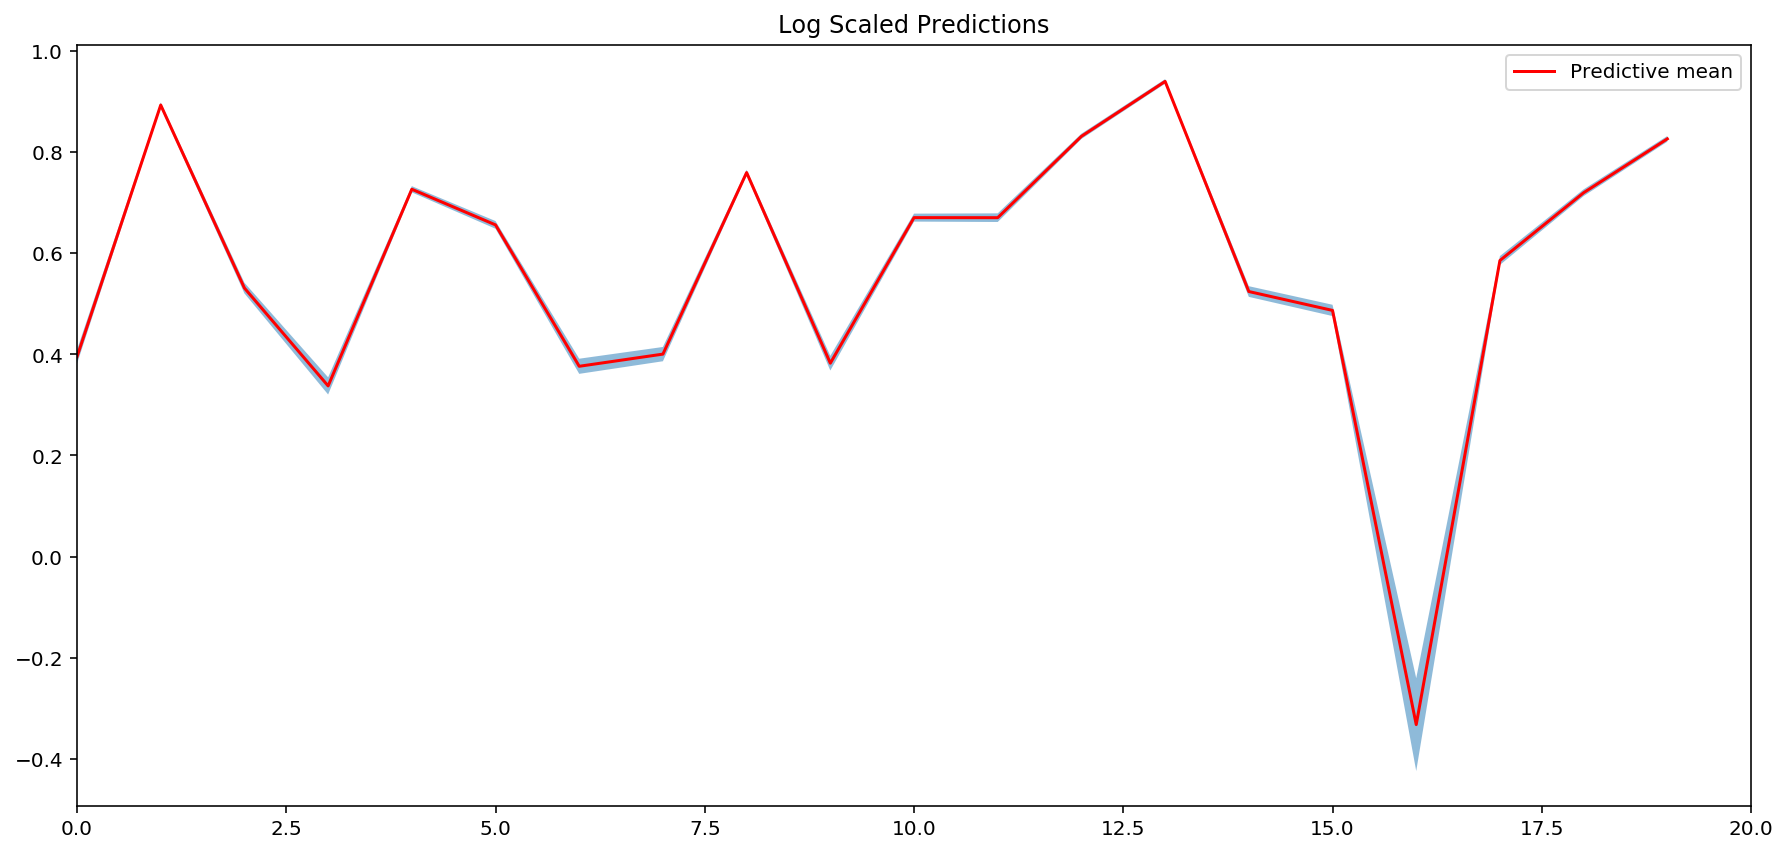

In [18]:
idx = range(len(y_means[:]))
plt.figure(figsize = (15, 7))
#plt.plot(idx, y_train[:], 'black', marker = '+', label = 'Ground Truth')
plt.plot(idx, y_means[:], 'r-', label='Predictive mean');
plt.fill_between(idx, y_means[:] + 2 * y_sigmas[:],
                 y_means[:] - 2 * y_sigmas[:], alpha=0.5)
plt.xlim(0, 20)
plt.legend()
plt.title('Log Scaled Predictions');

In [27]:
#wape = implement_wape(y_train, y_means) .97% no really
wape = .97

In [28]:
experiments = utils.get_experiment_df(permuts[:len(y_means)].copy(), y_means, y_sigmas, wape, scaler, continuous_cols)

In [31]:
experiments.sort_values(by = 'Certainty').head()

,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,...,Input2_PUR,Input2_PVC,Input3_LiBF4,Input3_LiCF3SO3,Input3_LiClO4,Input3_LiClO6,Input3_LiI,Input3_LiTFSI,Target,Certainty
16,2059.672281,310.996129,697.441164,42.381302,968.065254,178.092795,923.443523,50.321574,232.411321,35.788453,...,0,0,0,0,0,1,0,0,0.366400,10.113433
3,15630.548798,1886.014850,760.456639,46.092981,373.280003,603.853457,555.999165,45.696061,718.162569,64.667089,...,0,0,0,1,0,0,0,0,66.903482,83.396421
6,17358.411463,1993.889827,25.663763,59.034006,965.120021,101.491080,553.040563,45.130795,654.387761,34.937625,...,0,0,0,0,0,0,1,0,90.479002,85.335081
9,2939.362164,1886.349156,862.936263,25.781006,231.354400,136.012690,628.399948,51.828018,1630.939556,95.542722,...,0,0,0,0,0,1,0,0,94.877722,85.843406
7,5316.390415,1526.403297,48.372527,41.475760,523.989855,2651.181662,775.621952,59.619721,305.957362,38.804675,...,0,0,0,1,0,0,0,0,109.094849,86.177475


In [137]:
explore_df = experiments.query('Certainty > 0 and Certainty < 20').sort_values(by = 'Target').head(10)
explore_df

,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,...,Input2_PUR,Input2_PVC,Input3_LiBF4,Input3_LiCF3SO3,Input3_LiClO4,Input3_LiClO6,Input3_LiI,Input3_LiTFSI,Target,Certainty
52,6267.852540,1536.208525,541.639618,27.923277,609.797672,2117.265760,818.573578,59.260437,78.14240,53.798662,...,0,0,0,0,0,1,0,0,4.828130,9.182983
10,14369.069739,1903.526255,885.679500,38.770018,335.715457,1513.811562,676.733651,45.037769,416.47467,122.155273,...,0,1,0,0,0,0,0,1,7.069625,12.788383


In [135]:
exploit_df = experiments.query('Certainty > 80').sort_values(by = 'Certainty').tail(10)
exploit_df

,Input4,Input5,Input6,Input7,Input8,Input9,Input10,Input11,Input12,Input13,...,Input2_PUR,Input2_PVC,Input3_LiBF4,Input3_LiCF3SO3,Input3_LiClO4,Input3_LiClO6,Input3_LiI,Input3_LiTFSI,Target,Certainty
4,17416.651277,1082.350229,616.606714,38.068557,569.426643,2822.267160,330.933828,51.781162,2142.301130,181.245247,...,0,0,0,0,0,0,0,1,9853.328363,80.631683
2,3957.432179,1242.485854,707.460350,32.618085,909.837276,1115.654575,320.941575,58.370031,1164.202950,61.331334,...,0,0,0,0,0,0,1,0,12252.332785,80.869194
79,11081.716155,178.504040,18.095549,48.995931,496.617499,2956.439242,748.869803,58.076865,1003.171364,75.165825,...,0,0,0,0,0,1,0,0,10772.571639,82.527397
67,16417.794002,514.092461,210.292537,39.863779,571.817573,1175.180413,658.304274,58.497611,2039.255875,118.822821,...,1,0,0,1,0,0,0,0,20968.717071,83.104874
21,11259.968175,1637.115590,813.613070,31.557101,34.288851,1705.364373,868.506568,41.278142,682.129473,134.854361,...,0,1,1,0,0,0,0,0,9952.649165,83.454781
55,15206.701102,313.520453,464.838741,38.623010,781.104105,2434.185832,909.082879,43.506824,1574.765659,181.976983,...,0,0,0,0,0,1,0,0,16010.508671,85.000847
39,16689.619438,1361.051104,108.173730,44.285994,103.779013,2817.685582,805.770503,41.203589,1543.164525,124.135084,...,0,0,0,0,0,1,0,0,21294.734156,85.006386
41,10278.267363,81.575398,855.955229,46.328589,182.775090,2890.979037,409.543608,54.537659,472.354639,39.395992,...,0,0,0,0,0,1,0,0,20246.864984,85.817818


In [7]:
n_epochs = 10000
lr = 5e-3
#batch_size = x_train.shape[0]
num = 50
wape = 7.78

df, scaler, continuous_cols = utils.xform_data(pd.read_csv('task.csv'))
permuts = utils.get_permutations(pd.read_csv('task.csv'), 100)

model = build_model(len(df.columns) - 1)
model.compile(loss=neg_log_likelihood_with_dist, optimizer=Adam(lr), metrics=['mse'])
model.load_weights('bnn_64_weights')

def main():
    y_Pred_list = utils.get_preds(model, permuts, num)
    means, sigmas = means_sigmas(y_pred_list)
    experiments = utils.get_experiment_df(permuts[:len(y_means)].copy(), y_means, y_sigmas, wape, scaler, continuous_cols)
    
main()

ValueError: Tensor conversion requested dtype float64 for Tensor with dtype float32: <tf.Tensor: id=874, shape=(4480,), dtype=float32, numpy=
array([ 1.3215318e-02, -5.5001199e-04, -2.5062356e-02, ...,
       -2.2497619e-05, -5.8185404e-05,  2.0790853e-06], dtype=float32)>